# Solanum identifier using Neural Networks

Contains the code to balance classes and create the training/val/test sets

# Environment preparations

## Dependencies

In [1]:
# For Python 3.7
#!pip install keras tensorflow matplotlib numpy pandas imblearn split-folders scikit-learn tensorflow-addons scikeras[tensorflow]

# For Python 3.10
#!pip install "keras==2.10.0" "tensorflow<2.11" matplotlib numpy pandas imblearn split-folders scikit-learn "tensorflow-addons<2.11"
#!pip install --no-deps keras-tuner


## Env vars

In [2]:
# Set this variable to the root path of where the files are located
%env DATA_LOCATION=P:\CODE\ITESM\tesis-dataset-downloader\solanum_output
%env CLEAN_DATA_FOLDER=z_clean_resized
%env CLEAN_SPLIT_DATA_FOLDER=z_clean_resized_split

# Allow an async memory allocation to avoid OOM errors when using multiple models
#%env TF_GPU_ALLOCATOR=cuda_malloc_async
%env TF_FORCE_GPU_ALLOW_GROWTH=true

!echo %DATA_LOCATION%

#!dir %DATA_LOCATION%

# Constants
import os

RANDOM_SEED = 1988
DATA_ROOT_LOCATION = os.environ["DATA_LOCATION"]
CLEAN_DATA_FOLDER = os.environ["CLEAN_DATA_FOLDER"]
CLEAN_SPLIT_DATA_FOLDER = os.environ["CLEAN_SPLIT_DATA_FOLDER"]

env: DATA_LOCATION=P:\CODE\ITESM\tesis-dataset-downloader\solanum_output
env: CLEAN_DATA_FOLDER=z_clean_resized
env: CLEAN_SPLIT_DATA_FOLDER=z_clean_resized_split
env: TF_FORCE_GPU_ALLOW_GROWTH=true
P:\CODE\ITESM\tesis-dataset-downloader\solanum_output


## Imports

In [3]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import img_to_array

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow_addons as tfa

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from numpy import array

import pandas as pd

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import splitfolders

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, ShuffleSplit

from PIL import Image

import os
import time
from datetime import datetime

import random

# Enable 3rd Party Jupyter Widgets in Google Collab
#from google.colab import output
#output.enable_custom_widget_manager()

def get_training_device_name():
    name = tf.test.gpu_device_name()

    if "GPU" not in name:
        print("No GPU was found!, training will be done in the CPU which will be slower")
        name = '/cpu:0'
    else:
        print('Found GPU at: {}'.format(name))
    
    return name

TRAINING_DEVICE_NAME = get_training_device_name()

random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(
    RANDOM_SEED
)

Found GPU at: /device:GPU:0


## Tools

In [4]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

def count_rows_by_column(df, column):
    return df.groupby([column]).size().reset_index(name='count').sort_values("count", ascending=False)

def model_2_pkl(model, filename: str):
    """Exports a model to PKL format"""
    pickle.dump(model, open(filename, 'wb'))

def pkl_2_model(filename: str):
    """Loads a model from a PKL file"""
    return pickle.load(open(filename, 'rb'))

def get_class_names(generator) -> list:
    return [k for k, _ in sorted(generator.class_indices.items(), key = lambda item: item[1])]

def generate_id() -> str:
    # Generates an ID in the shape of YYYYMMDDhhmmss to be used in models and files
    return datetime.today().strftime('%Y%m%d%H%M%S')

def show_images(df: pd.DataFrame,
                labels_col_name="section",
                rows=2,
                cols=2,
                samples_per_label=1,
                figsize=(15,15)):
    
    sections = np.sort(df[labels_col_name].unique())

    for section in sections:
        parent_fig = plt.figure(section, figsize=figsize)
        plt.title(section)
        plt.axis("off")

        samples = df[df[labels_col_name]==section].sample(samples_per_label,
                                                          random_state=RANDOM_SEED)
        samples = [Image.open(path) for path in samples["full_path"]]
    
        grid = ImageGrid(parent_fig,
                         rect=111, # This will set the axes position as (left, bottom, width, height) tuple or as a three-digit subplot position code, it’s 111 in our case
                         nrows_ncols=(rows, cols),  # creates rows,cols grid of axes
                         axes_pad=0.1,  # Padding between pictures
                        )

        for ax, im in zip(grid, samples):            
            ax.imshow(im)
            ax.axis("off")

        plt.show()

# Data preparation

## Data Loading

In [5]:
images_df = pd.read_csv(os.path.join(DATA_ROOT_LOCATION, CLEAN_DATA_FOLDER, "images_dedup_512x512_100picspersection.csv"))

# Update all paths to conform to the local structure (Only if running in a UN*X environment)

# 'P:/CODE/ITESM/tesis-dataset-downloader/solanum_output/z_clean_resized/acanthophora/acanthophora_acerifolium_1928496814_gbif_2700.jpg'
# path_to_replace = "P:/CODE/ITESM/tesis-dataset-downloader/solanum_output/z_clean_resized"
# images_df["full_path"] = images_df["full_path"].str.replace(path_to_replace, data_root_location)

display(images_df.describe(include="all"))


section      species  filesize_mb image_type source  \
count     8515         8515  8515.000000       8515   8515   
unique      12          112          NaN          1      2   
top     petota  lanceolatum          NaN        jpg   gbif   
freq      1733          533          NaN       8515   6103   
mean       NaN          NaN     0.029506        NaN    NaN   
std        NaN          NaN     0.005773        NaN    NaN   
min        NaN          NaN     0.012600        NaN    NaN   
25%        NaN          NaN     0.025500        NaN    NaN   
50%        NaN          NaN     0.029200        NaN    NaN   
75%        NaN          NaN     0.033200        NaN    NaN   
max        NaN          NaN     0.062900        NaN    NaN   

                                                full_path  
count                                                8515  
unique                                               8515  
top     P:/CODE/ITESM/tesis-dataset-downloader/solanum...  
freq                                                    1  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN

## Data at a glance

In [6]:
print_marquee("Classes")
count_per_section = count_rows_by_column(images_df, "section")
display(count_per_section)

display(count_per_section.describe())

print_marquee("Info")
display(images_df.info())



***********
* Classes *
***********


section  count
9            petota   1733
5        holophylla   1449
7         melongena   1442
11            torva   1332
2      brevantherum    811
10          solanum    577
3         dulcamara    389
4      herposolanum    224
8       micracantha    180
6        lasiocarpa    178
0      acanthophora    100
1   anarrhichomenum    100

count
count    12.000000
mean    709.583333
std     617.223027
min     100.000000
25%     179.500000
50%     483.000000
75%    1359.500000
max    1733.000000



********
* Info *
********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8515 entries, 0 to 8514
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   section      8515 non-null   object 
 1   species      8515 non-null   object 
 2   filesize_mb  8515 non-null   float64
 3   image_type   8515 non-null   object 
 4   source       8515 non-null   object 
 5   full_path    8515 non-null   object 
dtypes: float64(1), object(5)
memory usage: 399.3+ KB


None

## Splitting the test set

Given that we will sample/undersample our dataset, we need to remove 10% of the classes for testing so that we don't contaminate our results and have the model train on test samples, the rest that we get will be balanced.

In [7]:
# Iterate over each of the classes and use train test split to sample out 20% of each class
# put this 90% and 10% into new DataFrames

TEST_FRACTION = 0.1

def split_balanced_dataset(original_images_df, test_fraction=TEST_FRACTION, is_verbose=True):

    training_set = pd.DataFrame()
    test_set = pd.DataFrame()

    for section in original_images_df["section"].unique():
        images_for_section = original_images_df[original_images_df["section"] == section]

        test_set_section = images_for_section.sample(
            frac=test_fraction,
            random_state=RANDOM_SEED,
            replace=False
        )

        # Remove the test indices from the train set
        training_set_section = images_for_section.drop(test_set_section.index)

        if is_verbose:
            print_marquee(section)
            print(f"Before sampling: {images_for_section.shape}")
            print(f"Training set for section: {training_set_section.shape}")
            print(f"Test set for section: {test_set_section.shape}")

        training_set = pd.concat([training_set, training_set_section])
        test_set = pd.concat([test_set, test_set_section])

    # Shuffle the training set to avoid issues with CV later
    training_set = training_set.sample(frac=1, 
                                    random_state=RANDOM_SEED).reset_index(drop=True)
    
    return training_set, test_set

training_set, test_set = split_balanced_dataset(images_df)

print(f">>>Train DF: {training_set.shape}\n   Test DF: {test_set.shape}")




****************
* acanthophora *
****************
Before sampling: (100, 6)
Training set for section: (90, 6)
Test set for section: (10, 6)


*******************
* anarrhichomenum *
*******************
Before sampling: (100, 6)
Training set for section: (90, 6)
Test set for section: (10, 6)


****************
* brevantherum *
****************
Before sampling: (811, 6)
Training set for section: (730, 6)
Test set for section: (81, 6)


*************
* dulcamara *
*************
Before sampling: (389, 6)
Training set for section: (350, 6)
Test set for section: (39, 6)


****************
* herposolanum *
****************
Before sampling: (224, 6)
Training set for section: (202, 6)
Test set for section: (22, 6)


**************
* holophylla *
**************
Before sampling: (1449, 6)
Training set for section: (1304, 6)
Test set for section: (145, 6)


**************
* lasiocarpa *
**************
Before sampling: (178, 6)
Training set for section: (160, 6)
Test set for section: (18, 6)


*

In [8]:
print_marquee("Training")
training_count_per_section = count_rows_by_column(training_set, "section")
display(training_count_per_section)

print_marquee("Info")
display(training_count_per_section.describe())
display(training_set.info())


print_marquee("Test")
test_count_per_section = count_rows_by_column(test_set, "section")
display(test_count_per_section)

print_marquee("Info")
display(test_set.info())



************
* Training *
************


section  count
9            petota   1560
5        holophylla   1304
7         melongena   1298
11            torva   1199
2      brevantherum    730
10          solanum    519
3         dulcamara    350
4      herposolanum    202
8       micracantha    162
6        lasiocarpa    160
0      acanthophora     90
1   anarrhichomenum     90



********
* Info *
********


count
count    12.000000
mean    638.666667
std     555.574123
min      90.000000
25%     161.500000
50%     434.500000
75%    1223.750000
max    1560.000000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7664 entries, 0 to 7663
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   section      7664 non-null   object 
 1   species      7664 non-null   object 
 2   filesize_mb  7664 non-null   float64
 3   image_type   7664 non-null   object 
 4   source       7664 non-null   object 
 5   full_path    7664 non-null   object 
dtypes: float64(1), object(5)
memory usage: 359.4+ KB


None



********
* Test *
********


section  count
9            petota    173
5        holophylla    145
7         melongena    144
11            torva    133
2      brevantherum     81
10          solanum     58
3         dulcamara     39
4      herposolanum     22
6        lasiocarpa     18
8       micracantha     18
0      acanthophora     10
1   anarrhichomenum     10



********
* Info *
********
<class 'pandas.core.frame.DataFrame'>
Int64Index: 851 entries, 77 to 8054
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   section      851 non-null    object 
 1   species      851 non-null    object 
 2   filesize_mb  851 non-null    float64
 3   image_type   851 non-null    object 
 4   source       851 non-null    object 
 5   full_path    851 non-null    object 
dtypes: float64(1), object(5)
memory usage: 46.5+ KB


None

## Balancing of classes

We can see that there are classes that are overrepresented, so we need to do some undersampling and oversampling in order for the model to better learn and classify.

The average count for the samples in the training set is `638.88` while the median is `434` (listed as the 2nd quartile or 50%), so the best strategy that will be employed is to randomly undersample anything above `500` and oversample anything below that level.

In [9]:
# As an experiment, we will train the model with just the pictures that have
#  at least 1000 samples to debug why we are not seeing the neural network learn
#  and ignore the sections that have less than that

#SAMPLE_SIZE = 1000
#sections_with_1000 =  list(training_count_per_section[training_count_per_section["count"] >= SAMPLE_SIZE]["section"].values)

#balanced_training_data = training_set[training_set["section"].isin(sections_with_1000)].reset_index()

#display(count_rows_by_column(balanced_training_data, "section"))

In [10]:
# https://imbalanced-learn.org/stable/

SAMPLE_SIZE = 1500

sections_to_oversample = list(training_count_per_section[training_count_per_section["count"] < SAMPLE_SIZE]["section"].values)
sections_to_undersample = list(training_count_per_section[training_count_per_section["count"] > SAMPLE_SIZE]["section"].values)

undersampler = RandomUnderSampler(sampling_strategy={k: SAMPLE_SIZE for k in sections_to_undersample},
                                  random_state=RANDOM_SEED)

oversampler = RandomOverSampler(sampling_strategy={k: SAMPLE_SIZE for k in sections_to_oversample},
                                  random_state=RANDOM_SEED)


def imbsample(imbsampler, df):
    """Applies a sampling strategy to a Pandas DataFrame using imblearn
    
    The imblearn only accepts the features and labels separately, so let's join
    the columns after the operations to get a single DataFrame
    
    :returns the df with sampled data 
    """
    X, y = imbsampler.fit_resample(df.drop("section", axis=1), df["section"])
    return pd.concat([X, y], axis=1)

balanced_training_data = imbsample(oversampler, training_set)
balanced_training_data = imbsample(undersampler, balanced_training_data)

# Shuffle the data
balanced_training_data = balanced_training_data.sample(frac=1,
                                                       random_state=RANDOM_SEED).reset_index(drop=True)

display(balanced_training_data.head(10))
display(count_rows_by_column(balanced_training_data, "section"))


species  filesize_mb image_type   source  \
0        hirtum       0.0315        jpg     gbif   
1     erianthum       0.0270        jpg  idigbio   
2   lanceolatum       0.0311        jpg  idigbio   
3     pubigerum       0.0234        jpg     gbif   
4         nudum       0.0367        jpg     gbif   
5  myriacanthum       0.0445        jpg     gbif   
6     pubigerum       0.0309        jpg  idigbio   
7     refractum       0.0360        jpg     gbif   
8     rostratum       0.0313        jpg  idigbio   
9     oxycarpum       0.0430        jpg     gbif   

                                           full_path       section  
0  P:/CODE/ITESM/tesis-dataset-downloader/solanum...    lasiocarpa  
1  P:/CODE/ITESM/tesis-dataset-downloader/solanum...  brevantherum  
2  P:/CODE/ITESM/tesis-dataset-downloader/solanum...         torva  
3  P:/CODE/ITESM/tesis-dataset-downloader/solanum...    holophylla  
4  P:/CODE/ITESM/tesis-dataset-downloader/solanum...    holophylla  
5  P:/CODE/ITESM/tesis-dataset-downloader/solanum...  acanthophora  
6  P:/CODE/ITESM/tesis-dataset-downloader/solanum...    holophylla  
7  P:/CODE/ITESM/tesis-dataset-downloader/solanum...  herposolanum  
8  P:/CODE/ITESM/tesis-dataset-downloader/solanum...     melongena  
9  P:/CODE/ITESM/tesis-dataset-downloader/solanum...        petota

section  count
0      acanthophora   1500
1   anarrhichomenum   1500
2      brevantherum   1500
3         dulcamara   1500
4      herposolanum   1500
5        holophylla   1500
6        lasiocarpa   1500
7         melongena   1500
8       micracantha   1500
9            petota   1500
10          solanum   1500
11            torva   1500

### Sample of images

In [11]:
show_images(balanced_training_data,
            rows=3,
            cols=3,
            figsize=(7, 7),
            samples_per_label=9)

Output hidden; open in https://colab.research.google.com to view.

## Data augmentation

In [12]:
TARGET_SIZE = (224, 224)

# BATCH_SIZE = 32
BATCH_SIZE = 16
COLOR_MODE = "rgb"
X_COL = "full_path"
Y_COL = "section"

image_data_gen_params = {
    "target_size": TARGET_SIZE,
    "color_mode": COLOR_MODE,
    "class_mode": "categorical",
    "seed": RANDOM_SEED,
    "save_prefix": 'augmented_',
    "save_format": 'png',
}

def get_train_generator(preprocessing_func, training_df, batch_size=BATCH_SIZE):
    train_datagen = ImageDataGenerator(
                rescale=1.0/255, # Normalize the data to be 0-1
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest',
                preprocessing_function=preprocessing_func)
    
    # return train_datagen.flow_from_directory(
    #   os.path.join(DATA_ROOT_LOCATION, CLEAN_SPLIT_DATA_FOLDER, "train"),
    #   # save_to_dir=os.path.join(DATA_ROOT_LOCATION, CLEAN_SPLIT_DATA_FOLDER, "train"),
    #   **image_data_gen_params)
    
    return train_datagen.flow_from_dataframe(
        training_df,
        x_col=X_COL,
        y_col=Y_COL,
        batch_size=batch_size,
        # save_to_dir=os.path.join(DATA_ROOT_LOCATION, CLEAN_SPLIT_DATA_FOLDER, "train"),
        shuffle=True,
        **image_data_gen_params)

def get_val_generator(df, preprocessing_func, batch_size=BATCH_SIZE):

    test_datagen = ImageDataGenerator(
        rescale=1.0/255,
        preprocessing_function=preprocessing_func,
    )

    return test_datagen.flow_from_dataframe(
            df,
            # save_to_dir=os.path.join(DATA_ROOT_LOCATION, CLEAN_SPLIT_DATA_FOLDER, "val"),
            x_col=X_COL,
            y_col=Y_COL,
            shuffle=False,
            batch_size=batch_size,
            **image_data_gen_params)

# Model candidate training

We will perform Cross-Validation = 4 to find the best architecture and with it, we'll train again on all of the training set and proceed to validate it on the test set.

In [13]:
CV_FOLDS = 4
NUM_CLASSES = len(balanced_training_data["section"].unique())
VAL_SIZE = 0.20

TRAINING_RUN_ID = generate_id()

In [14]:
def train_model(model_to_fit: tf.keras.models.Model,
                fit_params: dict,
                preproc_func):

    t = time.process_time()
    print_marquee(f"Started at {t}...")

    batch_size = fit_params.get("batch_size", BATCH_SIZE)
    
    # Transform from DataFrames to File System Generator
    # Make a copy of fit_params so as not to edit the original dictionary
    fit_params = fit_params.copy()
    fit_params["x"] = get_train_generator(preproc_func,
                                          fit_params["x"],
                                          batch_size=batch_size)
    fit_params["validation_data"] = get_val_generator(fit_params["validation_data"],
                                                      preproc_func,
                                                      batch_size)
    
    trained_model_history = model_to_fit.fit(**fit_params)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model_history

def evaluate_model(trained_model: tf.keras.models.Model,
                   trained_model_history,
                   fit_params: dict,
                   preproc_func,
                   print_loss_graphs: bool=True,
                   print_model_info: bool=True) -> tf.keras.models.Model:

    if print_model_info:
        print_marquee("Model Summary")                                
        trained_model.summary()

    batch_size = fit_params.get("batch_size", BATCH_SIZE)

    print_marquee("Validation Dataset Confusion Matrix")
    
    val_gen = get_val_generator(fit_params["validation_data"],
                                preproc_func,
                                batch_size=batch_size)

    val_model_predictions = trained_model.predict(val_gen,
                                                  #steps=val_gen.n // (val_gen.batch_size + 1)
                                                 )
    
    pred_report = print_dataset_prediction_report(val_model_predictions,
                                                  val_gen.classes,
                                                  get_class_names(val_gen),
                                                  print_cm_as_percentages=True)

    if print_loss_graphs:
        
        print_marquee("Train/Val Accuracy and Loss graphs")

        # If using early stopping, it might be the case that we used less epochs than
        #  requested
        subtitle = f"Epochs: {len(trained_model_history.history['accuracy'])}"
        
        graph_loss_accuracy(trained_model_history,
                            subtitle=subtitle)
    
    return val_model_predictions, pred_report

# Helper functions for reporting

def print_dataset_prediction_report(y_pred,
                                    y_real,
                                    labels: list=None,
                                    print_cm_as_percentages: bool=False):
    
    # y_pred = np.round(y_pred).astype(int)
    y_pred = np.argmax(y_pred, axis=1)

    print_marquee("Classification Report")
    class_report_str = classification_report(y_real,
                                             y_pred,
                                             target_names=labels,
                                             digits=4)
    class_report_dict = classification_report(y_real,
                                              y_pred,
                                              target_names=labels,
                                              output_dict=True)
    print(class_report_str)
    
    print_marquee("Confusion Matrix")
    cm_data = confusion_matrix(y_real,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_data,
                                        display_labels=labels)
    cm_display.plot(xticks_rotation="vertical")
    plt.show()

    if print_cm_as_percentages:
        print_marquee("Confusion Matrix as percentages")
        cm_data_perc = np.round(cm_data/np.sum(cm_data), 2)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_data_perc,
                                            display_labels=labels)
        cm_display.plot(xticks_rotation="vertical")
        plt.show()
    
    return class_report_dict


def graph_loss_accuracy(h_model,
                        subtitle: str = ""):
    
    num_records = len(h_model.history["accuracy"])
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,num_records),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,num_records),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

def create_model_checkpoint(filepath: str) -> tf.keras.callbacks.ModelCheckpoint:

    return tf.keras.callbacks.ModelCheckpoint(
            filepath,
            monitor = 'val_accuracy',
            verbose = 1,
            save_best_only = True,
            save_weights_only = False,
            mode = 'auto',
            # save_freq = 1,
        )

def calculate_cv_mean_metrics(cv_val_predictions):
    print_marquee(f"Mean metrics across {len(cv_val_predictions)} folds")
    display(pd.json_normalize(cv_val_predictions).mean().to_frame())


## VGG16



***************************
* Started at 10.734375... *
***************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
128/128 [==============================] - ETA: 0s - loss: 409.0229 - accuracy: 0.0767
Epoch 1: val_accuracy improved from -inf to 0.05625, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_20230216171100_1.h5
128/128 [==============================] - 39s 234ms/step - loss: 409.0229 - accuracy: 0.0767 - val_loss: 2.7961 - val_accuracy: 0.0562
Epoch 2/105
128/128 [==============================] - ETA: 0s - loss: 2.5968 - accuracy: 0.0898
Epoch 2: val_accuracy improved from 0.05625 to 0.06250, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_20230216171100_1.h5
128/128 [==============================] - 32s 249ms/step - loss: 2.5968 - accuracy: 0.0898 - val_loss: 2.4935 - val_accuracy: 0.0625
Epoch 3/105
128/128 [=

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

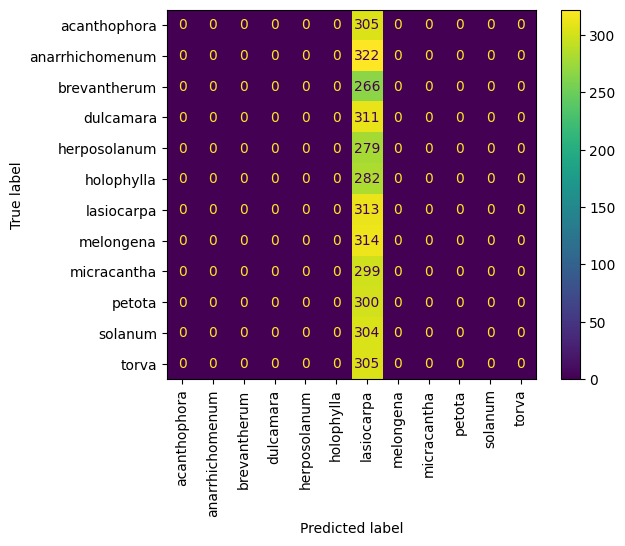



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


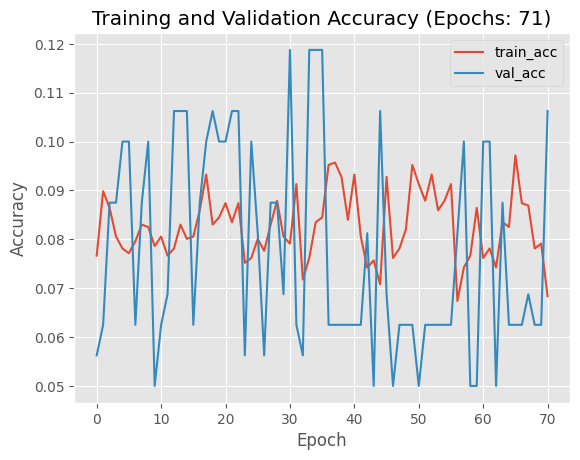

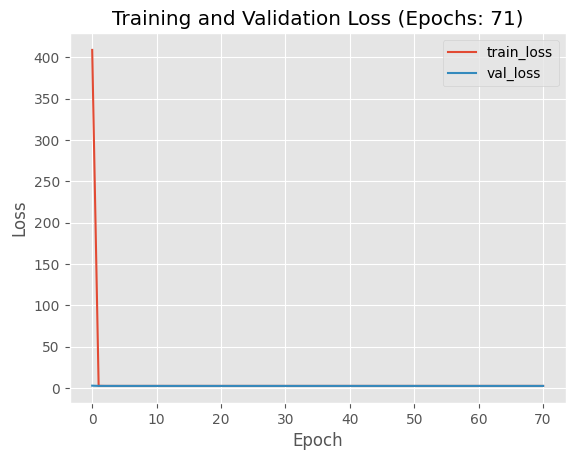



****************************
* Started at 2074.59375... *
****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
128/128 [==============================] - ETA: 0s - loss: 140.9845 - accuracy: 0.0869
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_20230216171100_2.h5
128/128 [==============================] - 27s 207ms/step - loss: 140.9845 - accuracy: 0.0869 - val_loss: 2.4867 - val_accuracy: 0.0812
Epoch 2/105
128/128 [==============================] - ETA: 0s - loss: 2.4871 - accuracy: 0.0884
Epoch 2: val_accuracy did not improve from 0.08125
128/128 [==============================] - 13s 102ms/step - loss: 2.4871 - accuracy: 0.0884 - val_loss: 2.4844 - val_accuracy: 0.0812
Epoch 3/105
128/128 [==============================] - ETA: 0s - loss: 2.4860 - accuracy: 0.0811
Epoch 3: val_accuracy i

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

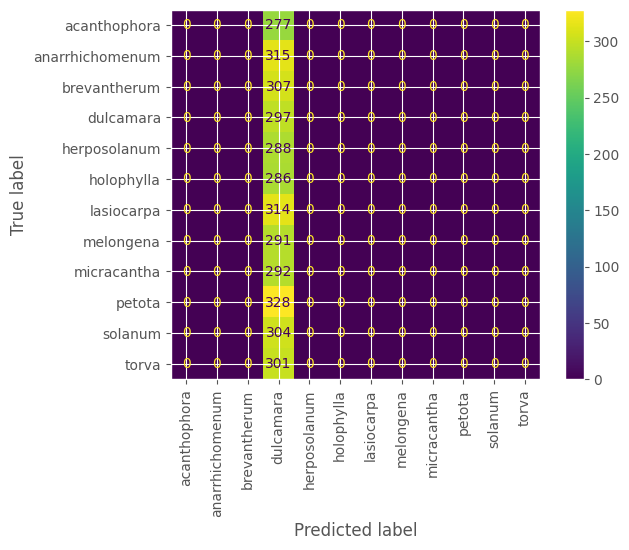



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


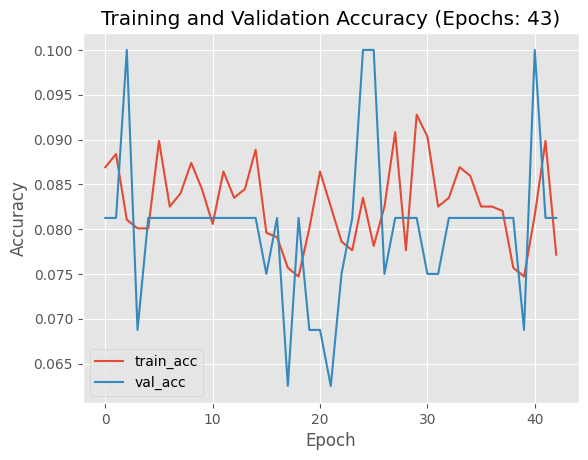

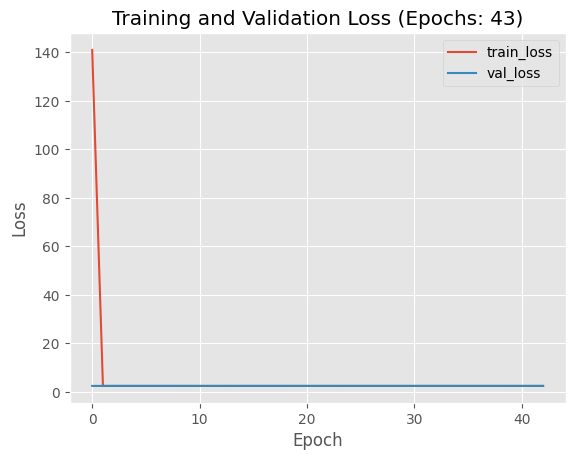



*****************************
* Started at 3323.390625... *
*****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
128/128 [==============================] - ETA: 0s - loss: 76.3238 - accuracy: 0.0898
Epoch 1: val_accuracy improved from -inf to 0.05000, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_20230216171100_3.h5
128/128 [==============================] - 28s 213ms/step - loss: 76.3238 - accuracy: 0.0898 - val_loss: 2.4914 - val_accuracy: 0.0500
Epoch 2/105
128/128 [==============================] - ETA: 0s - loss: 2.4865 - accuracy: 0.0752
Epoch 2: val_accuracy improved from 0.05000 to 0.07500, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_20230216171100_3.h5
128/128 [==============================] - 35s 273ms/step - loss: 2.4865 - accuracy: 0.0752 - val_loss: 2.4854 - val_accuracy: 0.0750
Epoch 3/105
128/12

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

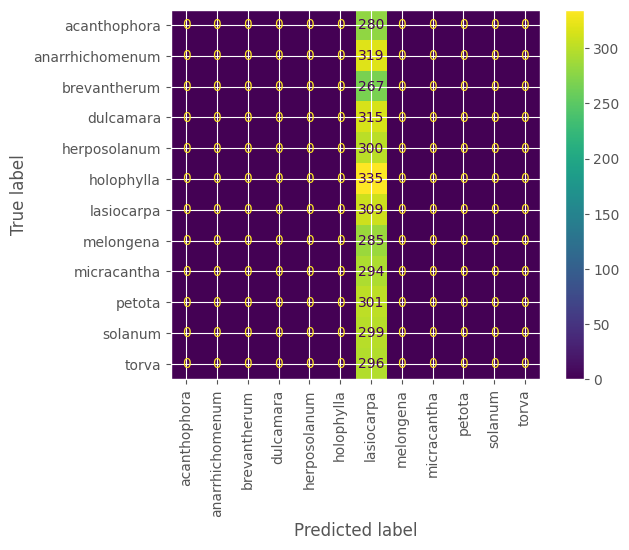



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


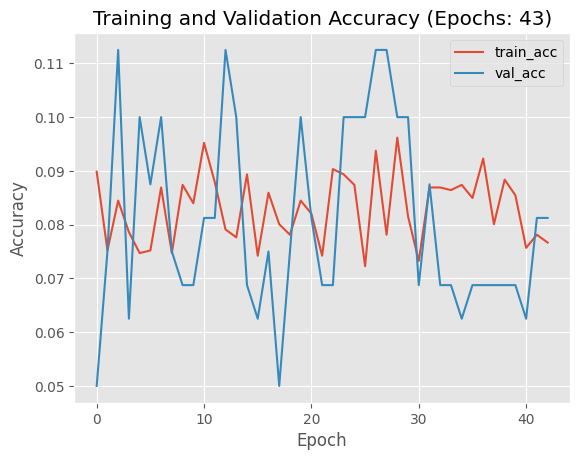

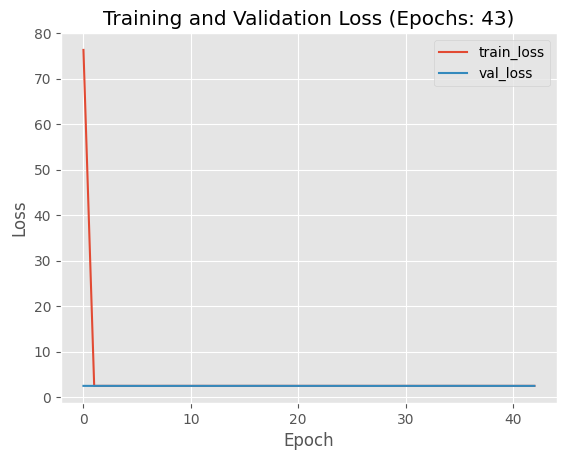



****************************
* Started at 4561.78125... *
****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
128/128 [==============================] - ETA: 0s - loss: 201.7437 - accuracy: 0.0762
Epoch 1: val_accuracy improved from -inf to 0.06875, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_20230216171100_4.h5
128/128 [==============================] - 31s 236ms/step - loss: 201.7437 - accuracy: 0.0762 - val_loss: 2.4879 - val_accuracy: 0.0688
Epoch 2/105
128/128 [==============================] - ETA: 0s - loss: 2.4928 - accuracy: 0.0889
Epoch 2: val_accuracy did not improve from 0.06875
128/128 [==============================] - 13s 101ms/step - loss: 2.4928 - accuracy: 0.0889 - val_loss: 2.4808 - val_accuracy: 0.0688
Epoch 3/105
128/128 [==============================] - ETA: 0s - loss: 2.4869 - accuracy: 0.0840
Epoch 3: val_accuracy i

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

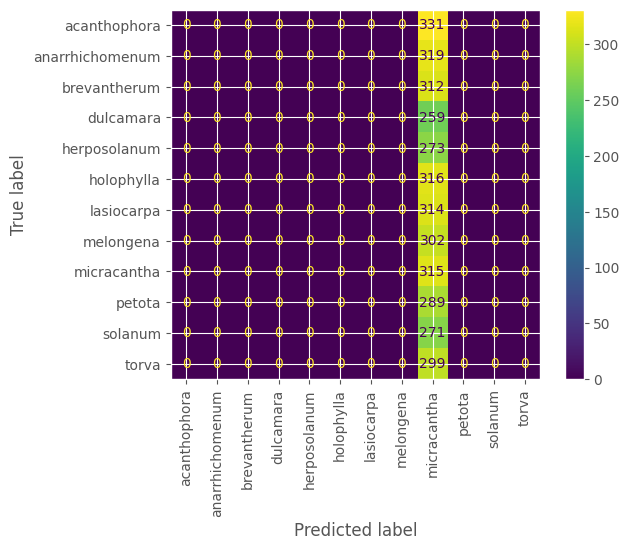



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


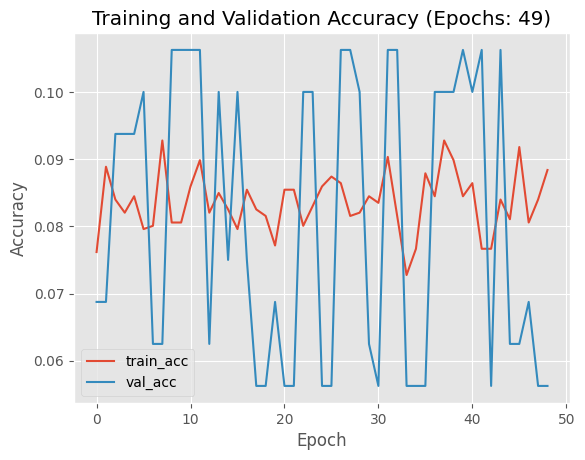

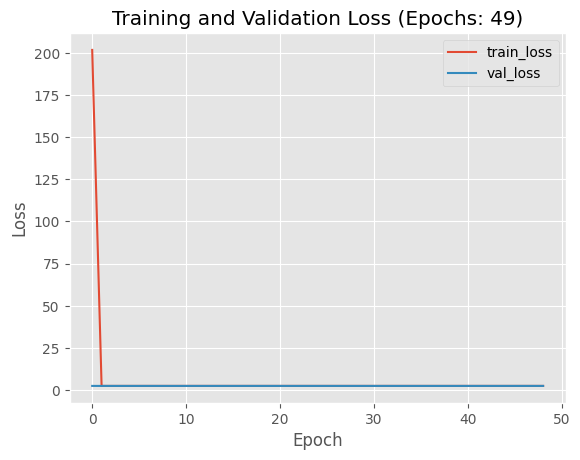



*******************************
* Mean metrics across 4 folds *
*******************************


0
accuracy                      0.085694
acanthophora.precision        0.000000
acanthophora.recall           0.000000
acanthophora.f1-score         0.000000
acanthophora.support        298.250000
anarrhichomenum.precision     0.000000
anarrhichomenum.recall        0.000000
anarrhichomenum.f1-score      0.000000
anarrhichomenum.support     318.750000
brevantherum.precision        0.000000
brevantherum.recall           0.000000
brevantherum.f1-score         0.000000
brevantherum.support        288.000000
dulcamara.precision           0.020625
dulcamara.recall              0.250000
dulcamara.f1-score            0.038106
dulcamara.support           295.500000
herposolanum.precision        0.000000
herposolanum.recall           0.000000
herposolanum.f1-score         0.000000
herposolanum.support        285.000000
holophylla.precision          0.000000
holophylla.recall             0.000000
holophylla.f1-score           0.000000
holophylla.support          304.750000
lasiocarpa.precision          0.043194
lasiocarpa.recall             0.500000
lasiocarpa.f1-score           0.079519
lasiocarpa.support          312.500000
melongena.precision           0.000000
melongena.recall              0.000000
melongena.f1-score            0.000000
melongena.support           298.000000
micracantha.precision         0.021875
micracantha.recall            0.250000
micracantha.f1-score          0.040230
micracantha.support         300.000000
petota.precision              0.000000
petota.recall                 0.000000
petota.f1-score               0.000000
petota.support              304.500000
solanum.precision             0.000000
solanum.recall                0.000000
solanum.f1-score              0.000000
solanum.support             294.500000
torva.precision               0.000000
torva.recall                  0.000000
torva.f1-score                0.000000
torva.support               300.250000
macro avg.precision           0.007141
macro avg.recall              0.083333
macro avg.f1-score            0.013155
macro avg.support          3600.000000
weighted avg.precision        0.007347
weighted avg.recall           0.085694
weighted avg.f1-score         0.013534
weighted avg.support       3600.000000

CPU times: total: 1h 39min 21s
Wall time: 50min 45s


In [ ]:
%%time

#kf = KFold(n_splits=CV_FOLDS,
#           random_state=RANDOM_SEED,
#           shuffle=True)
kf = ShuffleSplit(n_splits=CV_FOLDS,
                  test_size=VAL_SIZE,
                  random_state=RANDOM_SEED)

split = 1

vgg16_cv_val_pred = []

for train_index, val_index in kf.split(balanced_training_data):

    vgg16_tf_model = tf.keras.applications.vgg16.VGG16(
        include_top=True,
        weights=None,
        pooling="avg",
        classes=NUM_CLASSES,
        classifier_activation='softmax',
    )

    # Add an optimizer
    vgg16_tf_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    #vgg16_tf_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9),
    #                        loss='categorical_crossentropy',
    #                        metrics=['accuracy'])

    # Add a progress bar and save checkpoints
    vgg16_callbacks = [
        create_model_checkpoint(os.path.join(DATA_ROOT_LOCATION, f"vgg16_{TRAINING_RUN_ID}_{split}.h5")),
        tf.keras.callbacks.ProgbarLogger(
            count_mode = 'steps',
            stateful_metrics = None
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=40,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]
        
    training_split_data = balanced_training_data.iloc[train_index]
    val_split_data = balanced_training_data.iloc[val_index]

    fit_params = {
        "x": training_split_data,
        "epochs": 105,
        "callbacks": vgg16_callbacks,
        "validation_data": val_split_data,
        "steps_per_epoch": 128,
        "validation_steps": 10,
    }

    preproc_func = tf.keras.applications.vgg16.preprocess_input

    with tf.device(TRAINING_DEVICE_NAME):

        vgg16_training_history = train_model(vgg16_tf_model,
                                             fit_params=fit_params,
                                             preproc_func=preproc_func)
        
        _, pred_report = evaluate_model(vgg16_tf_model,
                                        vgg16_training_history,
                                        fit_params=fit_params,
                                        preproc_func=preproc_func)
        
        vgg16_cv_val_pred.append(pred_report)
    
    split += 1

calculate_cv_mean_metrics(vgg16_cv_val_pred)


## VGG16 with ImageNet Transfer Learning



***************************
* Started at 12.171875... *
***************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 17.7204 - accuracy: 0.1318
Epoch 1: val_accuracy improved from -inf to 0.14375, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_1.h5
64/64 [==============================] - 47s 664ms/step - loss: 17.7204 - accuracy: 0.1318 - val_loss: 2.7921 - val_accuracy: 0.1437
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.1072 - accuracy: 0.2393
Epoch 2: val_accuracy improved from 0.14375 to 0.29375, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_1.h5
64/64 [==============================] - 42s 653ms/step - loss: 2.1072 - accuracy: 0.2393 - val_loss: 1.9249 - val_accuracy: 0.2937
Epoch 3/105
64/64 [=======

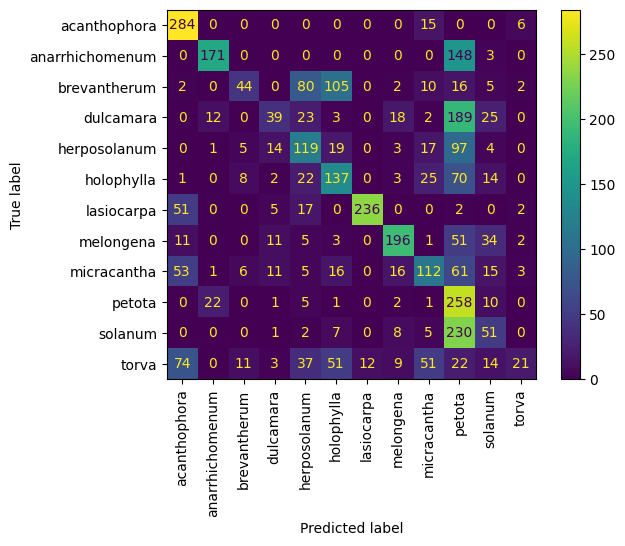



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


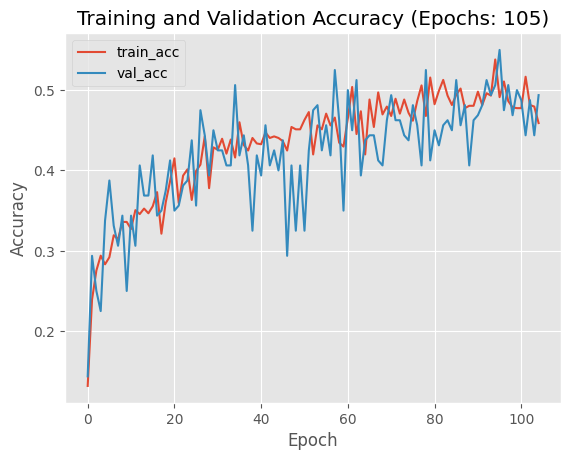

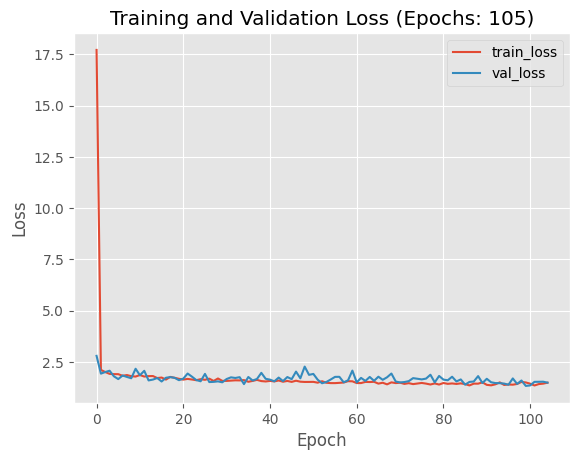



*****************************
* Started at 1211.296875... *
*****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 16.3871 - accuracy: 0.1191
Epoch 1: val_accuracy improved from -inf to 0.18125, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_2.h5
64/64 [==============================] - 28s 438ms/step - loss: 16.3871 - accuracy: 0.1191 - val_loss: 2.2480 - val_accuracy: 0.1813
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.1493 - accuracy: 0.2236
Epoch 2: val_accuracy improved from 0.18125 to 0.25000, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_2.h5
64/64 [==============================] - 27s 418ms/step - loss: 2.1493 - accuracy: 0.2236 - val_loss: 2.0837 - val_accuracy: 0.2500
Epoch 3/105
64/64 [=

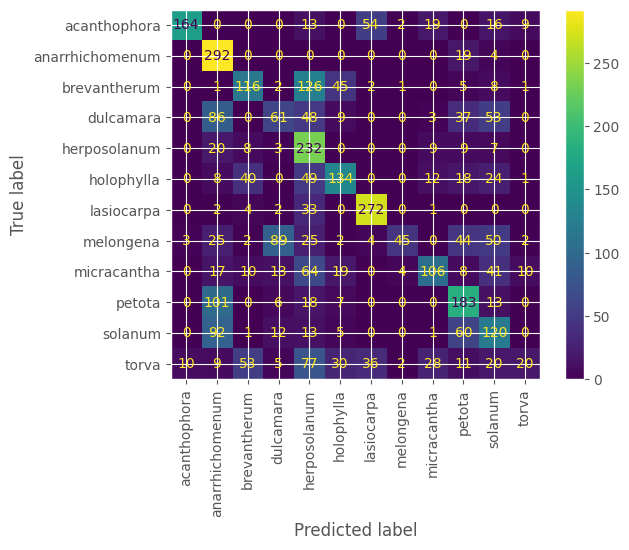



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


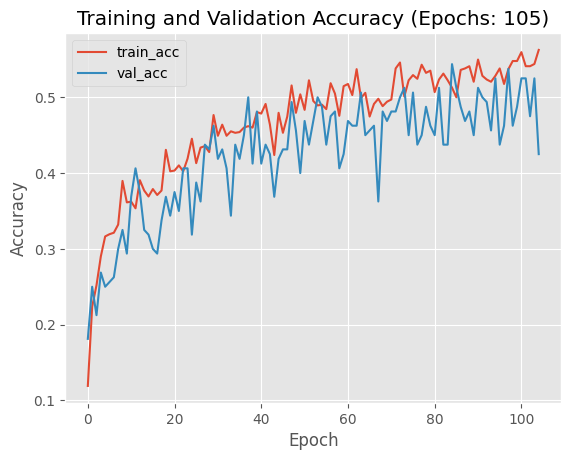

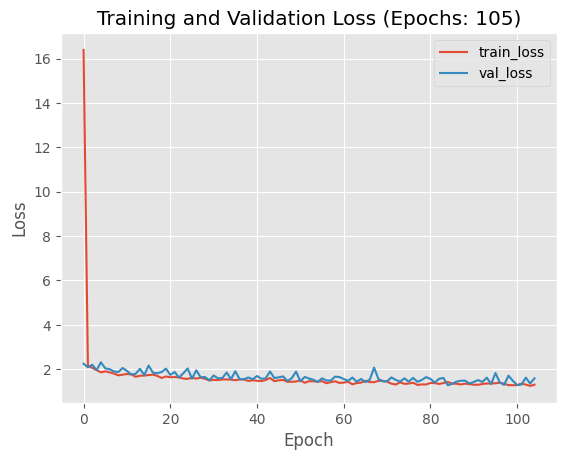



*****************************
* Started at 2373.234375... *
*****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 13.9492 - accuracy: 0.1250
Epoch 1: val_accuracy improved from -inf to 0.17500, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_3.h5
64/64 [==============================] - 26s 410ms/step - loss: 13.9492 - accuracy: 0.1250 - val_loss: 2.2366 - val_accuracy: 0.1750
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.2193 - accuracy: 0.2012
Epoch 2: val_accuracy improved from 0.17500 to 0.29375, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_3.h5
64/64 [==============================] - 24s 370ms/step - loss: 2.2193 - accuracy: 0.2012 - val_loss: 1.9254 - val_accuracy: 0.2937
Epoch 3/105
64/64 [=

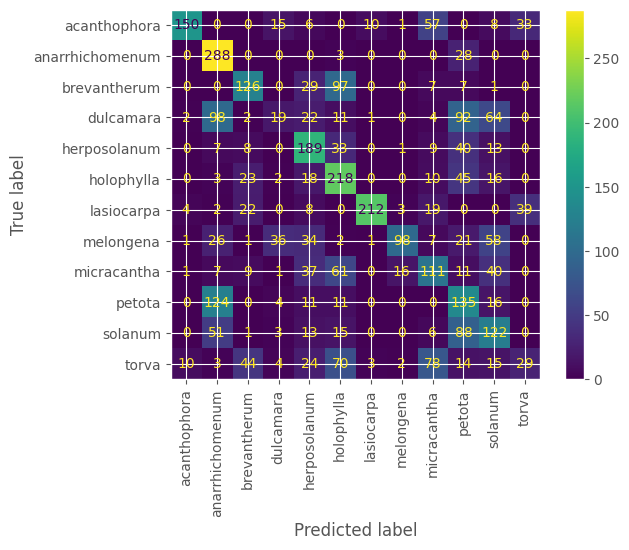



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


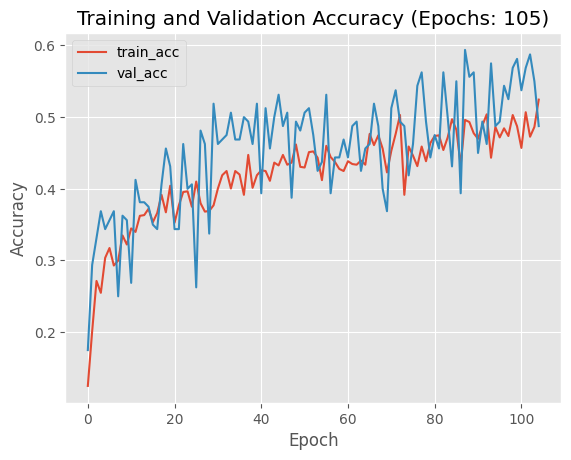

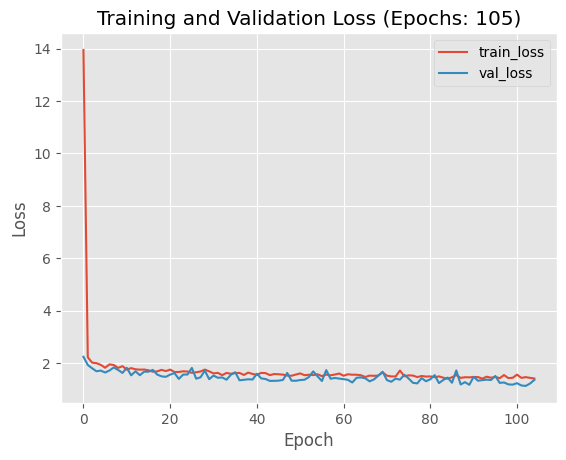



***************************
* Started at 3531.6875... *
***************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 14.9412 - accuracy: 0.1270
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_4.h5
64/64 [==============================] - 23s 360ms/step - loss: 14.9412 - accuracy: 0.1270 - val_loss: 3.7976 - val_accuracy: 0.1250
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.2030 - accuracy: 0.1904
Epoch 2: val_accuracy improved from 0.12500 to 0.21875, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16_tl_20230217091009_4.h5
64/64 [==============================] - 31s 494ms/step - loss: 2.2030 - accuracy: 0.1904 - val_loss: 1.9452 - val_accuracy: 0.2188
Epoch 3/105
64/64 [=======

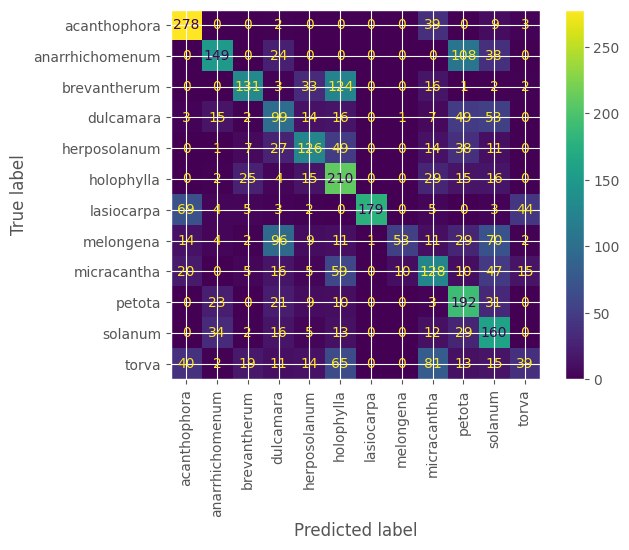



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


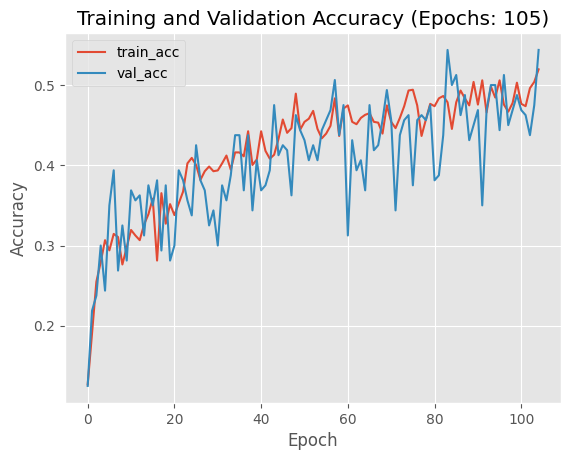

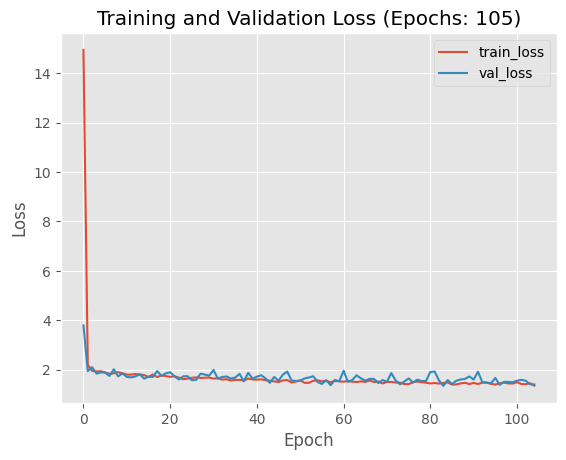



*******************************
* Mean metrics across 4 folds *
*******************************


0
accuracy                      0.475972
acanthophora.precision        0.767927
acanthophora.recall           0.724700
acanthophora.f1-score         0.713952
acanthophora.support        298.250000
anarrhichomenum.precision     0.595728
anarrhichomenum.recall        0.706986
anarrhichomenum.f1-score      0.602344
anarrhichomenum.support     318.750000
brevantherum.precision        0.571459
brevantherum.recall           0.358761
brevantherum.f1-score         0.425595
brevantherum.support        288.000000
dulcamara.precision           0.324495
dulcamara.recall              0.193336
dulcamara.f1-score            0.220247
dulcamara.support           295.500000
herposolanum.precision        0.434159
herposolanum.recall           0.580904
herposolanum.f1-score         0.479326
herposolanum.support        285.000000
holophylla.precision          0.432474
holophylla.recall             0.567413
holophylla.f1-score           0.482154
holophylla.support          304.750000
lasiocarpa.precision          0.904777
lasiocarpa.recall             0.719096
lasiocarpa.f1-score           0.788687
lasiocarpa.support          312.500000
melongena.precision           0.808505
melongena.recall              0.324550
melongena.f1-score            0.429940
melongena.support           298.000000
micracantha.precision         0.448051
micracantha.recall            0.380374
micracantha.f1-score          0.405778
micracantha.support         300.000000
petota.precision              0.341838
petota.recall                 0.632698
petota.f1-score               0.426575
petota.support              304.500000
solanum.precision             0.331441
solanum.recall                0.390233
solanum.f1-score              0.347896
solanum.support             294.500000
torva.precision               0.426752
torva.recall                  0.090926
torva.f1-score                0.144653
torva.support               300.250000
macro avg.precision           0.532301
macro avg.recall              0.472498
macro avg.f1-score            0.455596
macro avg.support          3600.000000
weighted avg.precision        0.533449
weighted avg.recall           0.475972
weighted avg.f1-score         0.458047
weighted avg.support       3600.000000

CPU times: total: 1h 17min 53s
Wall time: 1h 7min 28s


In [ ]:
%%time

kf = ShuffleSplit(n_splits=CV_FOLDS,
                  test_size=VAL_SIZE,
                  random_state=RANDOM_SEED)

split = 1

vgg16_tl_cv_val_pred = []

for train_index, val_index in kf.split(balanced_training_data):

    vgg16_tl_model = tf.keras.applications.vgg16.VGG16(
        include_top=True,
        weights='imagenet',
        pooling="avg",
        # classes=12,
        classifier_activation='softmax',
    )

    # Change the output prediction layer to support the 12 classes instead of the 1000 classes in ImageNet
    output = vgg16_tl_model.layers[-2].output
    predictions = tf.keras.layers.Dense(NUM_CLASSES,
                                        activation="softmax")(output)
    vgg16_tl_model = tf.keras.Model(inputs = vgg16_tl_model.input,
                                    outputs = predictions)

    # Freeze all layers but the FC and output
    for layer in (vgg16_tl_model.layers)[:19]:
        layer.trainable = False

    # Add an optimizer
    vgg16_tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    #vgg16_tl_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
    #                        loss='categorical_crossentropy',
    #                        metrics=['accuracy'])
        
    training_split_data = balanced_training_data.iloc[train_index]
    val_split_data = balanced_training_data.iloc[val_index]

    # Add a progress bar and save checkpoints
    vgg16_tl_callbacks = [
        create_model_checkpoint(os.path.join(DATA_ROOT_LOCATION, f"vgg16_tl_{TRAINING_RUN_ID}_{split}.h5")),
        tf.keras.callbacks.ProgbarLogger(
            count_mode = 'steps',
            stateful_metrics = None
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=40,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]

    fit_params = {
                    "x": training_split_data,
                    "epochs": 105,
                    "callbacks": vgg16_tl_callbacks,
                    "validation_data": val_split_data,
                    "steps_per_epoch": 64,
                    "validation_steps": 10,
                    }
    
    preproc_func = tf.keras.applications.vgg16.preprocess_input
        
    with tf.device(TRAINING_DEVICE_NAME):

        vgg16_tl_training_history = train_model(vgg16_tl_model,
                                                fit_params=fit_params,
                                                preproc_func=preproc_func)
        
        _, pred_report = evaluate_model(vgg16_tl_model,
                                        vgg16_tl_training_history,
                                        fit_params=fit_params,
                                        preproc_func=preproc_func)
    
        vgg16_tl_cv_val_pred.append(pred_report)

    split += 1

calculate_cv_mean_metrics(vgg16_tl_cv_val_pred)

## ResNET50



**************************
* Started at 11.59375... *
**************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 3.9523 - accuracy: 0.0850
Epoch 1: val_accuracy improved from -inf to 0.06875, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_20230216150341_1.h5
64/64 [==============================] - 16s 141ms/step - loss: 3.9523 - accuracy: 0.0850 - val_loss: 3304.0222 - val_accuracy: 0.0688
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.5358 - accuracy: 0.1260
Epoch 2: val_accuracy improved from 0.06875 to 0.13750, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_20230216150341_1.h5
64/64 [==============================] - 13s 200ms/step - loss: 2.5358 - accuracy: 0.1260 - val_loss: 13.0022 - val_accuracy: 0.1375
Epoch 3/105
64/64 [========

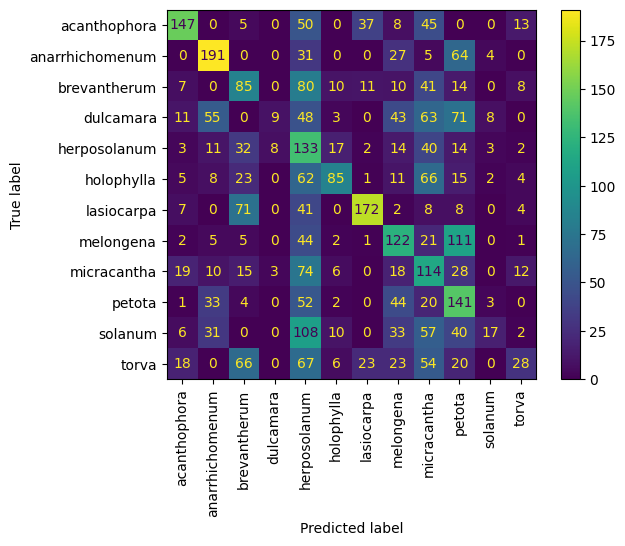



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


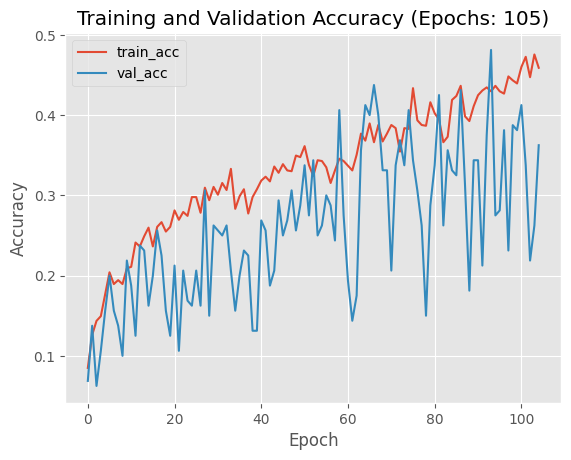

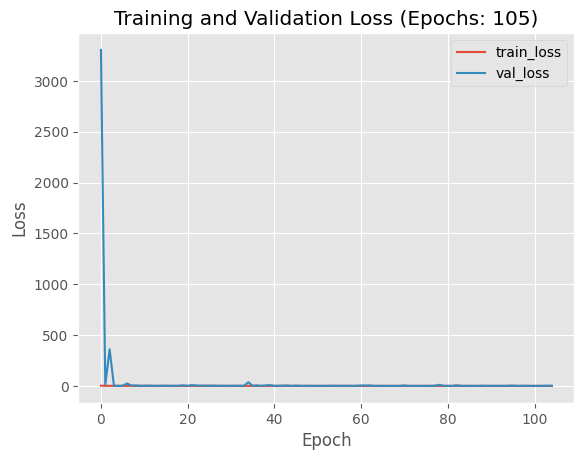



*****************************
* Started at 1455.921875... *
*****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 3.9492 - accuracy: 0.0811
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_20230216150341_2.h5
64/64 [==============================] - 12s 123ms/step - loss: 3.9492 - accuracy: 0.0811 - val_loss: 14135.5830 - val_accuracy: 0.0812
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.8075 - accuracy: 0.1084
Epoch 2: val_accuracy did not improve from 0.08125
64/64 [==============================] - 7s 103ms/step - loss: 2.8075 - accuracy: 0.1084 - val_loss: 44.9530 - val_accuracy: 0.0812
Epoch 3/105
64/64 [==============================] - ETA: 0s - loss: 2.5349 - accuracy: 0.1465
Epoch 3: val_accuracy did n

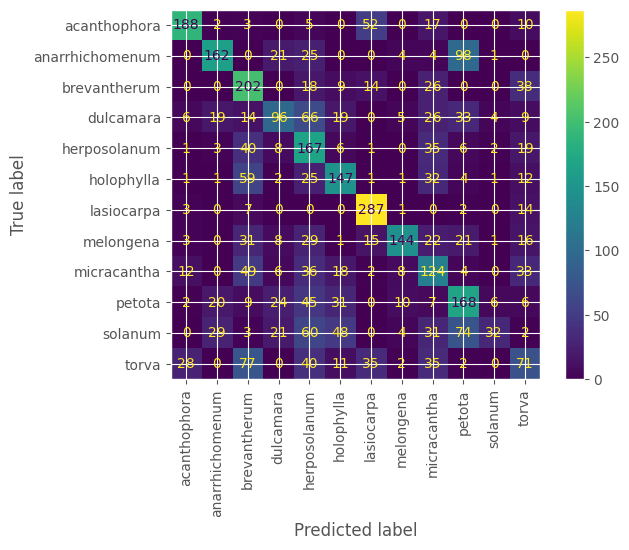



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


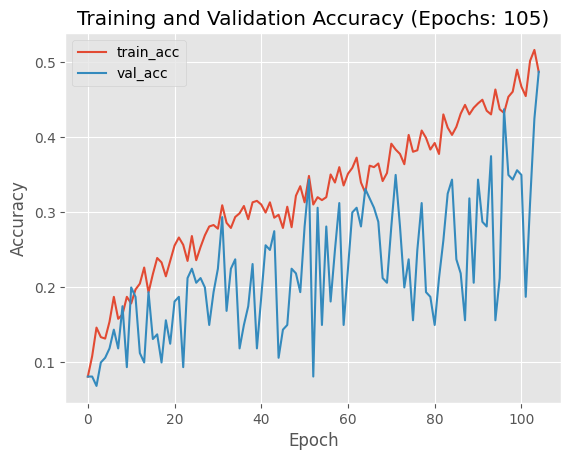

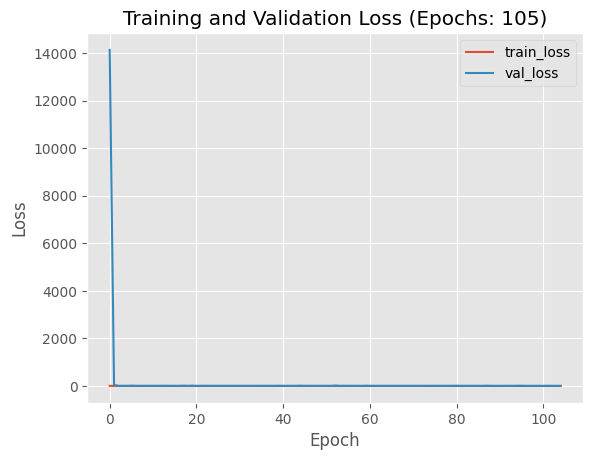



*****************************
* Started at 2871.140625... *
*****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 4.0296 - accuracy: 0.0947
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_20230216150341_3.h5
64/64 [==============================] - 11s 122ms/step - loss: 4.0296 - accuracy: 0.0947 - val_loss: 7.1974 - val_accuracy: 0.0938
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 3.0052 - accuracy: 0.1094
Epoch 2: val_accuracy did not improve from 0.09375
64/64 [==============================] - 7s 104ms/step - loss: 3.0052 - accuracy: 0.1094 - val_loss: 3251.5769 - val_accuracy: 0.0812
Epoch 3/105
64/64 [==============================] - ETA: 0s - loss: 2.6046 - accuracy: 0.1270
Epoch 3: val_accuracy improve

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

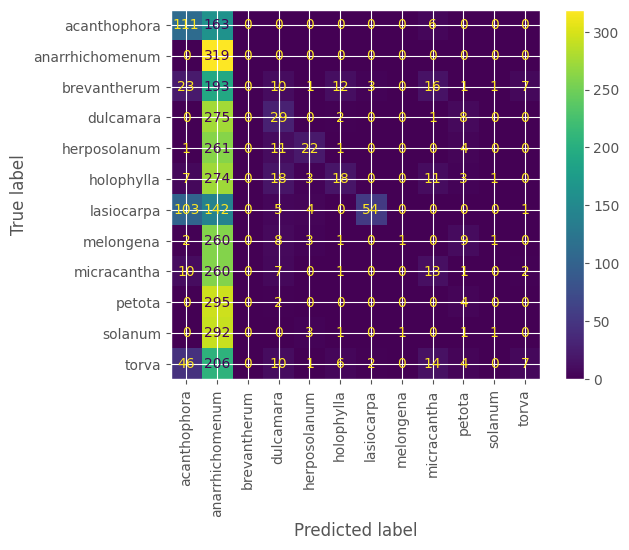



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


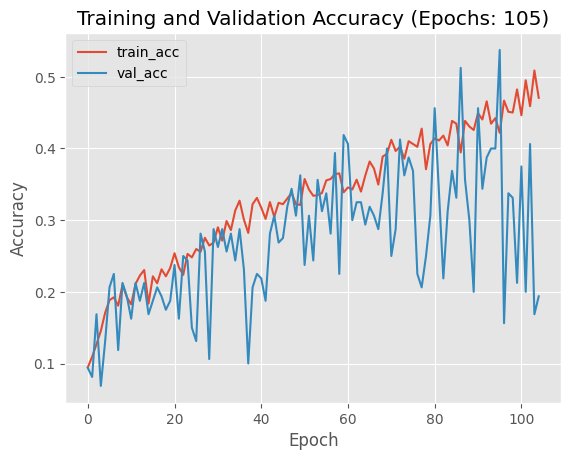

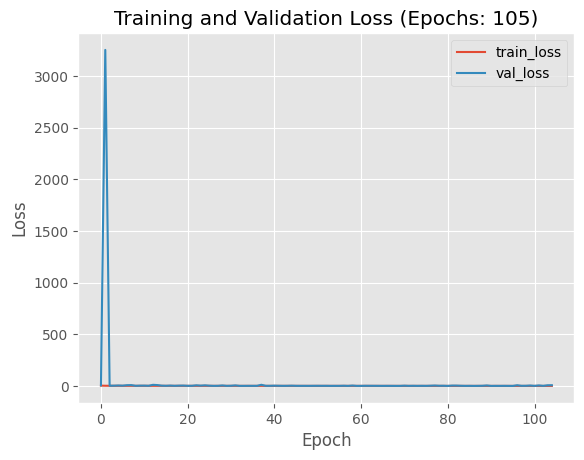



****************************
* Started at 4290.03125... *
****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 3.9890 - accuracy: 0.0918
Epoch 1: val_accuracy improved from -inf to 0.08750, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_20230216150341_4.h5
64/64 [==============================] - 12s 125ms/step - loss: 3.9890 - accuracy: 0.0918 - val_loss: 56.2198 - val_accuracy: 0.0875
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 2.8317 - accuracy: 0.1094
Epoch 2: val_accuracy did not improve from 0.08750
64/64 [==============================] - 7s 108ms/step - loss: 2.8317 - accuracy: 0.1094 - val_loss: 1518.9069 - val_accuracy: 0.0750
Epoch 3/105
64/64 [==============================] - ETA: 0s - loss: 2.6752 - accuracy: 0.1299
Epoch 3: val_accuracy improved 

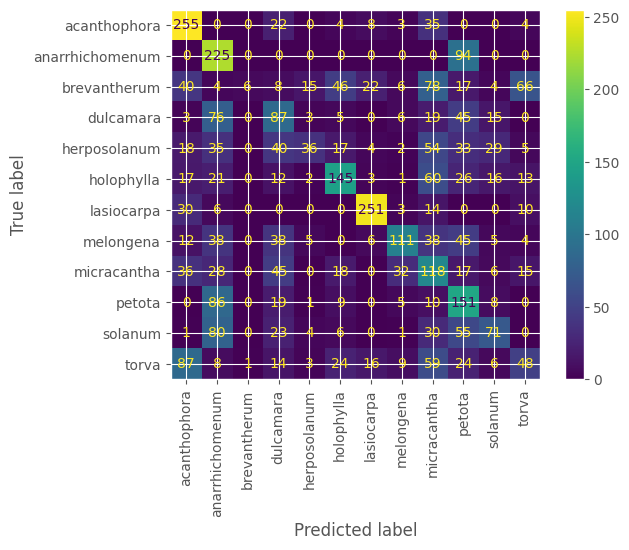



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


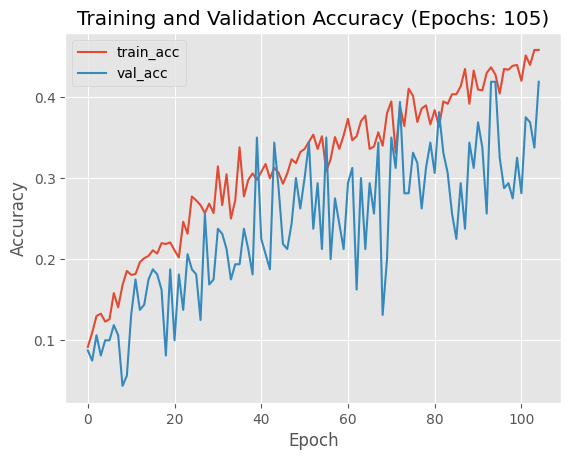

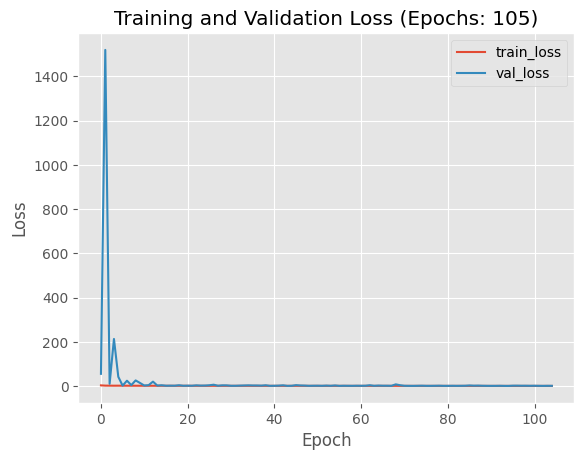



*******************************
* Mean metrics across 4 folds *
*******************************


0
accuracy                      0.355208
acanthophora.precision        0.574573
acanthophora.recall           0.581872
acanthophora.f1-score         0.567652
acanthophora.support        298.250000
anarrhichomenum.precision     0.430213
anarrhichomenum.recall        0.703196
anarrhichomenum.f1-score      0.460831
anarrhichomenum.support     318.750000
brevantherum.precision        0.385957
brevantherum.recall           0.249190
brevantherum.f1-score         0.209797
brevantherum.support        288.000000
dulcamara.precision           0.384649
dulcamara.recall              0.195036
dulcamara.f1-score            0.224633
dulcamara.support           295.500000
herposolanum.precision        0.402083
herposolanum.recall           0.315441
herposolanum.f1-score         0.251336
herposolanum.support        285.000000
holophylla.precision          0.516875
holophylla.recall             0.331999
holophylla.f1-score           0.374831
holophylla.support          304.750000
lasiocarpa.precision          0.781612
lasiocarpa.recall             0.609413
lasiocarpa.f1-score           0.627092
lasiocarpa.support          312.500000
melongena.precision           0.567061
melongena.recall              0.313610
melongena.f1-score            0.361499
melongena.support           298.000000
micracantha.precision         0.250282
micracantha.recall            0.306187
micracantha.f1-score          0.253060
micracantha.support         300.000000
petota.precision              0.271986
petota.recall                 0.379494
petota.f1-score               0.299666
petota.support              304.500000
solanum.precision             0.458515
solanum.recall                0.106630
solanum.f1-score              0.154527
solanum.support             294.500000
torva.precision               0.347437
torva.recall                  0.127967
torva.f1-score                0.166701
torva.support               300.250000
macro avg.precision           0.447604
macro avg.recall              0.351670
macro avg.f1-score            0.329302
macro avg.support          3600.000000
weighted avg.precision        0.450277
weighted avg.recall           0.355208
weighted avg.f1-score         0.331415
weighted avg.support       3600.000000

CPU times: total: 1h 34min 59s
Wall time: 51min 42s


In [ ]:
%%time

kf = ShuffleSplit(n_splits=CV_FOLDS,
                  test_size=VAL_SIZE,
                  random_state=RANDOM_SEED)

split = 1

resnet50_cv_val_pred = []

for train_index, val_index in kf.split(balanced_training_data):

    resnet50_model = tf.keras.applications.ResNet50(
        pooling="avg",
        include_top=True,
        weights=None,
        classes=NUM_CLASSES,
        classifier_activation='softmax'
    )

    # Add an optimizer
    resnet50_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    # resnet50_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9),
    #                        loss='categorical_crossentropy',
    #                        metrics=['accuracy'])

    training_split_data = balanced_training_data.iloc[train_index]
    val_split_data = balanced_training_data.iloc[val_index]

    # Add a progress bar and save checkpoints
    resnet50_callbacks = [
        create_model_checkpoint(os.path.join(DATA_ROOT_LOCATION, f"resnet50_{TRAINING_RUN_ID}_{split}.h5")),
        tf.keras.callbacks.ProgbarLogger(
            count_mode = 'steps',
            stateful_metrics = None
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=40,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]

    fit_params = {
            "x": training_split_data,
            "epochs": 105,
            "callbacks": resnet50_callbacks,
            "validation_data": val_split_data,
            "steps_per_epoch": 64,
            "validation_steps": 10,
    }

    preproc_func = tf.keras.applications.resnet50.preprocess_input
    
    with tf.device(TRAINING_DEVICE_NAME):

        resnet50_training_history = train_model(resnet50_model,
                                                fit_params=fit_params,
                                                preproc_func=preproc_func)
        
        _, pred_report = evaluate_model(resnet50_model,
                                        resnet50_training_history,
                                        fit_params=fit_params,
                                        preproc_func=preproc_func)
    
        resnet50_cv_val_pred.append(pred_report)
    
    split += 1

calculate_cv_mean_metrics(resnet50_cv_val_pred)


## RestNet50 with ImageNet Transfer Learning



****************************
* Started at 4408.09375... *
****************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 9.7812 - accuracy: 0.1016
Epoch 1: val_accuracy improved from -inf to 0.10625, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_1.h5
64/64 [==============================] - 11s 136ms/step - loss: 9.7812 - accuracy: 0.1016 - val_loss: 10.5562 - val_accuracy: 0.1063
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 4.6693 - accuracy: 0.1172
Epoch 2: val_accuracy improved from 0.10625 to 0.11250, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_1.h5
64/64 [==============================] - 8s 123ms/step - loss: 4.6693 - accuracy: 0.1172 - val_loss: 2.6248 - val_accuracy: 0.1125
Epoch 3/105
64/64 [

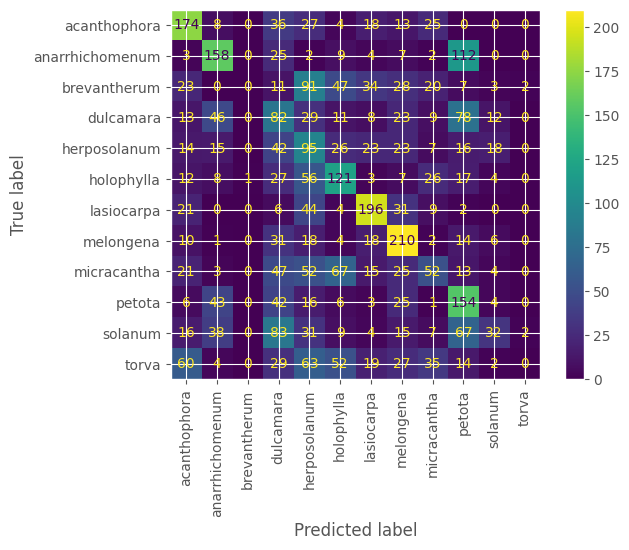



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


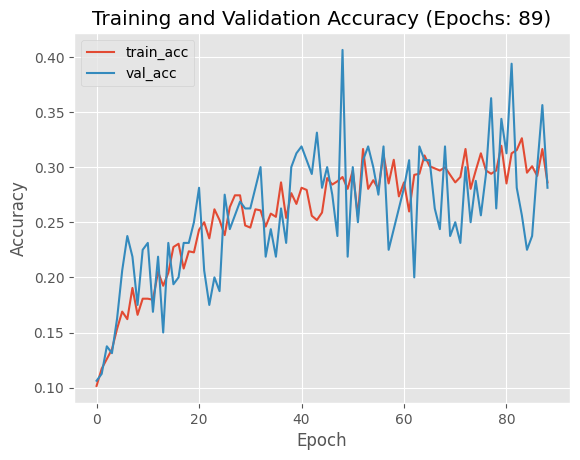

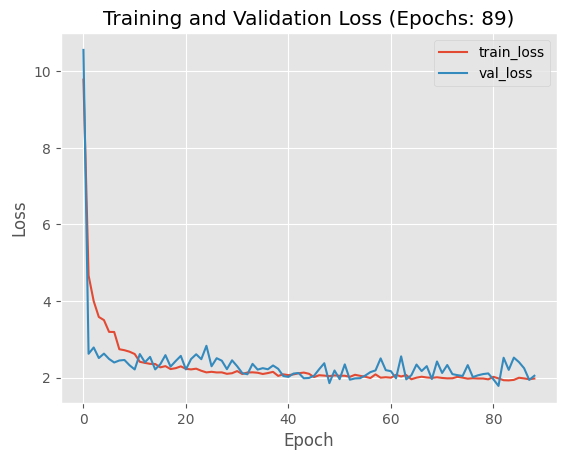



************************
* Started at 5497.0... *
************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 9.8503 - accuracy: 0.0977
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_2.h5
64/64 [==============================] - 11s 134ms/step - loss: 9.8503 - accuracy: 0.0977 - val_loss: 22.7142 - val_accuracy: 0.0812
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 4.5344 - accuracy: 0.1270
Epoch 2: val_accuracy improved from 0.08125 to 0.08750, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_2.h5
64/64 [==============================] - 8s 119ms/step - loss: 4.5344 - accuracy: 0.1270 - val_loss: 3.2108 - val_accuracy: 0.0875
Epoch 3/105
64/64 [============

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

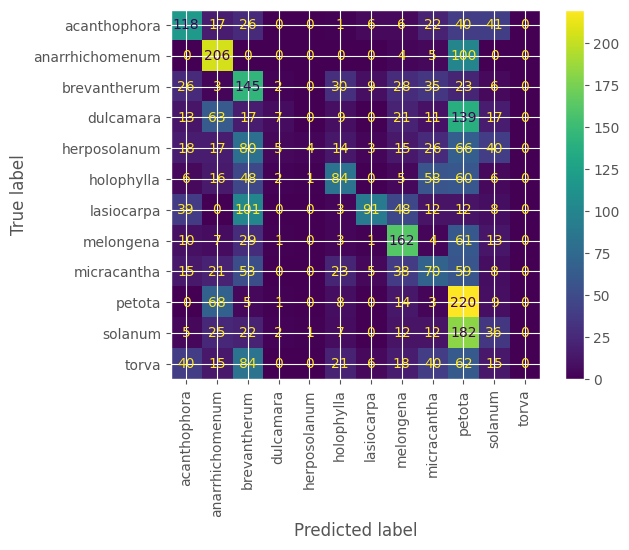



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


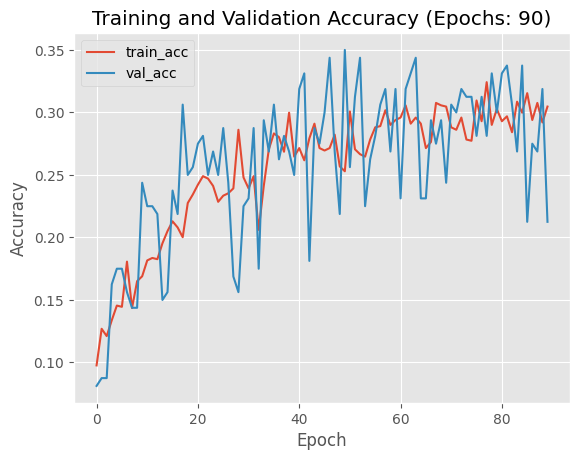

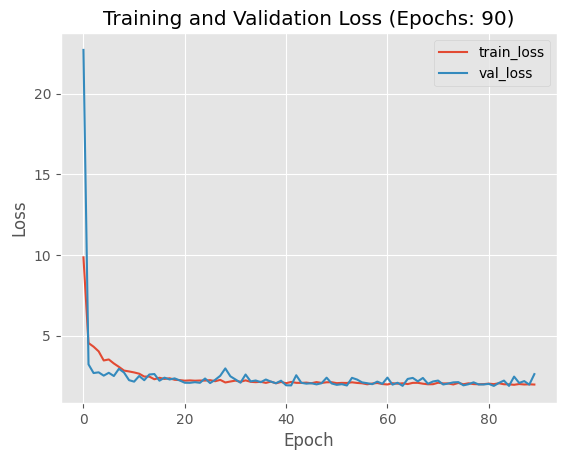



***************************
* Started at 6597.8125... *
***************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 11.1766 - accuracy: 0.1152
Epoch 1: val_accuracy improved from -inf to 0.10625, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_3.h5
64/64 [==============================] - 11s 133ms/step - loss: 11.1766 - accuracy: 0.1152 - val_loss: 43.4558 - val_accuracy: 0.1063
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 3.6561 - accuracy: 0.1084
Epoch 2: val_accuracy did not improve from 0.10625
64/64 [==============================] - 7s 113ms/step - loss: 3.6561 - accuracy: 0.1084 - val_loss: 9.2981 - val_accuracy: 0.1000
Epoch 3/105
64/64 [==============================] - ETA: 0s - loss: 3.5347 - accuracy: 0.1338
Epoch 3: val_accuracy improved f

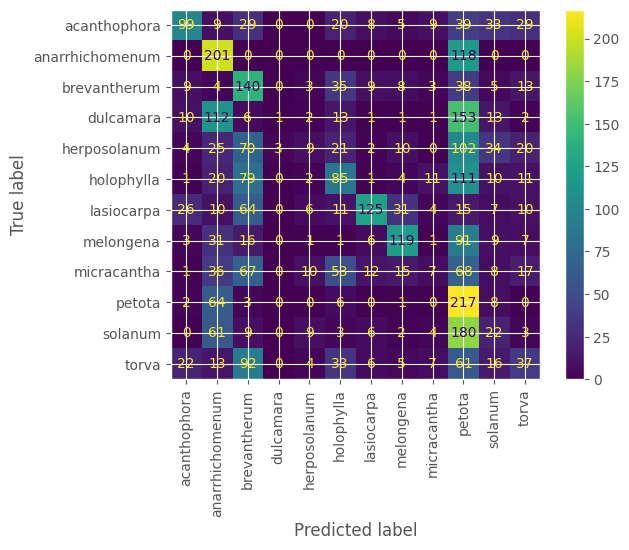



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


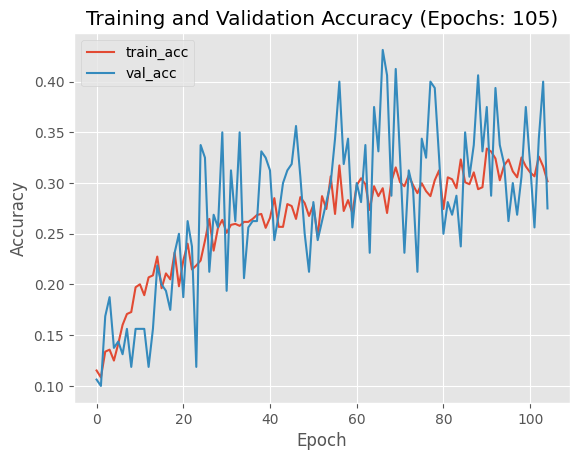

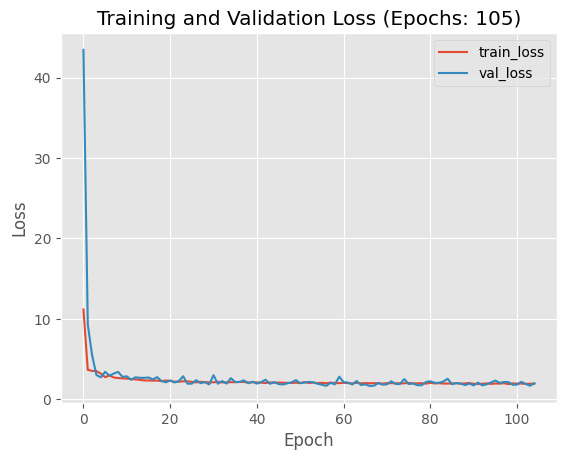



**************************
* Started at 7869.375... *
**************************
Found 14400 validated image filenames belonging to 12 classes.
Found 3600 validated image filenames belonging to 12 classes.
Epoch 1/105
64/64 [==============================] - ETA: 0s - loss: 10.8682 - accuracy: 0.1182
Epoch 1: val_accuracy improved from -inf to 0.10625, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_4.h5
64/64 [==============================] - 11s 131ms/step - loss: 10.8682 - accuracy: 0.1182 - val_loss: 27.3072 - val_accuracy: 0.1063
Epoch 2/105
64/64 [==============================] - ETA: 0s - loss: 3.4741 - accuracy: 0.1201
Epoch 2: val_accuracy improved from 0.10625 to 0.12500, saving model to P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\resnet50_tl_20230216202451_4.h5
64/64 [==============================] - 8s 123ms/step - loss: 3.4741 - accuracy: 0.1201 - val_loss: 7.4388 - val_accuracy: 0.1250
Epoch 3/105
64/64 [====

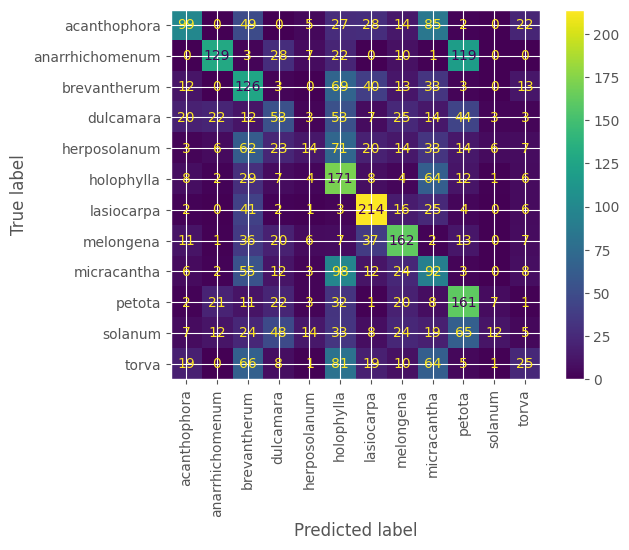



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


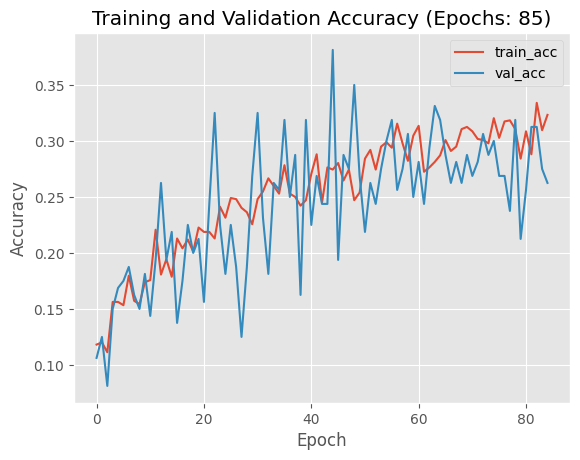

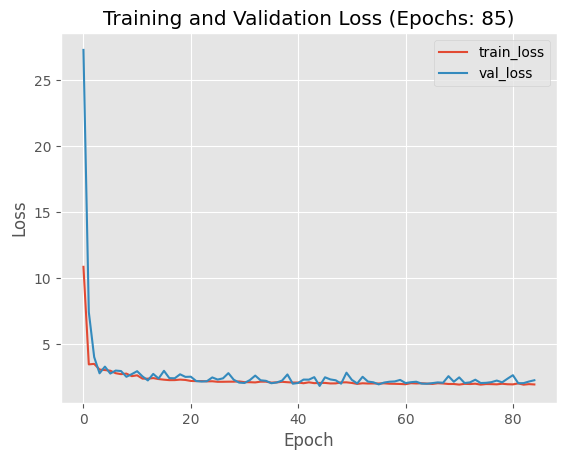



*******************************
* Mean metrics across 4 folds *
*******************************


0
accuracy                      0.328958
acanthophora.precision        0.489129
acanthophora.recall           0.412287
acanthophora.f1-score         0.435882
acanthophora.support        298.250000
anarrhichomenum.precision     0.485494
anarrhichomenum.recall        0.544784
anarrhichomenum.f1-score      0.492074
anarrhichomenum.support     318.750000
brevantherum.precision        0.181580
brevantherum.recall           0.350126
brevantherum.f1-score         0.238469
brevantherum.support        288.000000
dulcamara.precision           0.253097
dulcamara.recall              0.123761
dulcamara.f1-score            0.120356
dulcamara.support           295.500000
herposolanum.precision        0.318281
herposolanum.recall           0.108918
herposolanum.f1-score         0.099920
herposolanum.support        285.000000
holophylla.precision          0.327192
holophylla.recall             0.379414
holophylla.f1-score           0.336098
holophylla.support          304.750000
lasiocarpa.precision          0.643389
lasiocarpa.recall             0.500517
lasiocarpa.f1-score           0.533530
lasiocarpa.support          312.500000
melongena.precision           0.498678
melongena.recall              0.544865
melongena.f1-score            0.512118
melongena.support           298.000000
micracantha.precision         0.214898
micracantha.recall            0.182378
micracantha.f1-score          0.183145
micracantha.support         300.000000
petota.precision              0.267569
petota.recall                 0.615522
petota.f1-score               0.360635
petota.support              304.500000
solanum.precision             0.272677
solanum.recall                0.085386
solanum.f1-score              0.120557
solanum.support             294.500000
torva.precision               0.122760
torva.recall                  0.052153
torva.f1-score                0.072668
torva.support               300.250000
macro avg.precision           0.339562
macro avg.recall              0.325009
macro avg.f1-score            0.292121
macro avg.support          3600.000000
weighted avg.precision        0.341608
weighted avg.recall           0.328958
weighted avg.f1-score         0.295240
weighted avg.support       3600.000000

CPU times: total: 1h 15min 3s
Wall time: 45min 29s


In [ ]:
%%time

kf = ShuffleSplit(n_splits=CV_FOLDS,
                  test_size=VAL_SIZE,
                  random_state=RANDOM_SEED)

split = 1

resnet50_tl_cv_val_pred = []

for train_index, val_index in kf.split(balanced_training_data):

    resnet50_tl_model = tf.keras.models.Sequential(name="resnet50_imagenet")

    imagenet_resnet50_model= tf.keras.applications.ResNet50(
        include_top=False,
        pooling="max",
        input_shape=(224,224,3),
        classes=NUM_CLASSES,
        weights='imagenet',)

    for layer in imagenet_resnet50_model.layers[:-14]:
        layer.trainable=False


    # Add a custom FC layer for actual learning
    resnet50_tl_model.add(imagenet_resnet50_model)
    resnet50_tl_model.add(tf.keras.layers.Flatten())
    #resnet50_tl_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    #resnet50_tl_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    resnet50_tl_model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))

    # Add an optimizer
    resnet50_tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.003),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    #resnet50_tl_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9),
    #                        loss='categorical_crossentropy',
    #                        metrics=['accuracy'])
        
    training_split_data = balanced_training_data.iloc[train_index]
    val_split_data = balanced_training_data.iloc[val_index]

        # Add a progress bar and save checkpoints
    resnet50_tl_callbacks = [
        create_model_checkpoint(os.path.join(DATA_ROOT_LOCATION, f"resnet50_tl_{TRAINING_RUN_ID}_{split}.h5")),
        tf.keras.callbacks.ProgbarLogger(
            count_mode = 'steps',
            stateful_metrics = None
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0,
            patience=40,
            verbose=1,
            mode='auto',
            restore_best_weights=True
        )
    ]

    fit_params = {
        "x": training_split_data,
        "epochs": 105,
        "callbacks": resnet50_tl_callbacks,
        "validation_data": val_split_data,
        "steps_per_epoch": 64,
        "validation_steps": 10,
    }

    preproc_func = tf.keras.applications.resnet50.preprocess_input

    with tf.device(TRAINING_DEVICE_NAME):

        resnet50_tl_training_history = train_model(resnet50_tl_model,
                                                   fit_params=fit_params,
                                                   preproc_func=preproc_func)
        
        _, pred_report = evaluate_model(resnet50_tl_model,
                                        resnet50_tl_training_history,
                                        fit_params=fit_params,
                                        preproc_func=preproc_func)
        
        resnet50_tl_cv_val_pred.append(pred_report)
    
    split += 1

calculate_cv_mean_metrics(resnet50_tl_cv_val_pred)


# Hyperparameter search for the best performing model

Given the previous results, we'll move on to do a grid search to find the best
hyperparameters for the model.



In [ ]:
bal_training_set, bal_val_set = split_balanced_dataset(balanced_training_data, 0.1, is_verbose=False)
print(f">>>Train DF: {bal_training_set.shape}\n   Val DF: {bal_val_set.shape}")


>>>Train DF: (16200, 6)
   Val DF: (1800, 6)


In [ ]:
"""
fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

https://keras.io/guides/keras_tuner/getting_started/
https://keras.io/api/keras_tuner/hyperparameters/#choice-method
https://keras.io/guides/keras_tuner/custom_tuner/

"""
import keras_tuner


class MyBestArchitecture(keras_tuner.HyperModel):

    def build(self, hp):

        # Hyperparameters to tune
        model_pooling = hp.Choice("pooling", 
                                  ["avg", "max"],
                                  default="max")
        learning_rate = hp.Choice("learning_rate",
                                  [0.001, 0.01, 0.003, 0.03, 0.006, 0.06],
                                  default=0.01)
        trainable_layers_limit = hp.Choice("trainable_layers",
                                           [-1, -3, -4, -5],
                                           default=-1)
        optimizer_name = hp.Choice("optimizer",
                                   ["sgd", "adam"],
                                   default="sgd")

        vgg16_tl_model = tf.keras.applications.vgg16.VGG16(
            include_top=True,
            weights='imagenet',
            pooling=model_pooling,
            classifier_activation='softmax',
        )

        # Change the output prediction layer to support the 12 classes instead of the 1000 classes in ImageNet
        output = vgg16_tl_model.layers[-2].output
        predictions = tf.keras.layers.Dense(NUM_CLASSES,
                                            activation="softmax")(output)
        vgg16_tl_model = tf.keras.Model(inputs = vgg16_tl_model.input,
                                        outputs = predictions)

        # Freeze all layers but the FC and output
        for layer in (vgg16_tl_model.layers)[:trainable_layers_limit]:
            layer.trainable = False

        # Add an optimizer
        with hp.conditional_scope("optimizer", ["adam"]):
            if optimizer_name == "adam":
                optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
        with hp.conditional_scope("optimizer", ["sgd"]):
            if optimizer_name == "sgd":
                optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
                
        vgg16_tl_model.compile(optimizer=optimizer,
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])
        
        return vgg16_tl_model
    
    def fit(self, hp, model, x, y, **kwargs):

        # More hyperparameter to tune
        batch_size = hp.Choice("batch_size", [16, 32, 64, 128], default=32)
        
        # Add a progress bar and save checkpoints
        vgg16_tl_callbacks = [
            # create_model_checkpoint(os.path.join(DATA_ROOT_LOCATION, f"vgg16_hyperparam_{TRAINING_RUN_ID}.h5")),
            tf.keras.callbacks.ProgbarLogger(
                count_mode = 'steps',
                stateful_metrics = None
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                min_delta=0,
                patience=64,
                verbose=1,
                mode='auto',
                restore_best_weights=True
            )
        ]

        preproc_func = tf.keras.applications.vgg16.preprocess_input

        train_data_gen = get_train_generator(preproc_func, bal_training_set, batch_size)
        val_data_gen = get_val_generator(bal_val_set, preproc_func, batch_size)

        kwargs["callbacks"].extend(vgg16_tl_callbacks)

        fit_params = {
                        "x": train_data_gen, 
                        "validation_data": val_data_gen,
                        "steps_per_epoch": 64,
                        "validation_steps": 10,
                        "workers": 10,
                     }
        
        tf.keras.backend.clear_session()

        with tf.device(TRAINING_DEVICE_NAME):
            history = model.fit(**fit_params, **kwargs)

        return history

In [ ]:
%%time
random_tuner = keras_tuner.RandomSearch(
    MyBestArchitecture(),
    objective="val_accuracy",
    max_trials=4,
    seed=RANDOM_SEED,
    overwrite=True,
    directory=os.path.join(DATA_ROOT_LOCATION, "vgg16tl_hypertuner"),
    project_name="vgg16tl",
)

random_tuner.search(None, None, epochs=104)

display(random_tuner.search_space_summary())
display(random_tuner.results_summary())

Trial 4 Complete [00h 17m 14s]
val_accuracy: 0.5249999761581421

Best val_accuracy So Far: 0.840624988079071
Total elapsed time: 01h 00m 32s
INFO:tensorflow:Oracle triggered exit
Search space summary
Default search space size: 5
pooling (Choice)
{'default': 'max', 'conditions': [], 'values': ['avg', 'max'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.001, 0.01, 0.003, 0.03, 0.006, 0.06], 'ordered': True}
trainable_layers (Choice)
{'default': -1, 'conditions': [], 'values': [-1, -3, -4, -5], 'ordered': True}
optimizer (Choice)
{'default': 'sgd', 'conditions': [], 'values': ['sgd', 'adam'], 'ordered': False}
batch_size (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}


None

Results summary
Results in P:\CODE\ITESM\tesis-dataset-downloader\solanum_output\vgg16tl_hypertuner\vgg16tl
Showing 10 best trials
Trial summary
Hyperparameters:
pooling: max
learning_rate: 0.03
trainable_layers: -1
optimizer: adam
batch_size: 32
Score: 0.840624988079071
Trial summary
Hyperparameters:
pooling: max
learning_rate: 0.003
trainable_layers: -3
optimizer: adam
batch_size: 64
Score: 0.6343749761581421
Trial summary
Hyperparameters:
pooling: max
learning_rate: 0.001
trainable_layers: -4
optimizer: sgd
batch_size: 64
Score: 0.5249999761581421
Trial summary
Hyperparameters:
pooling: max
learning_rate: 0.03
trainable_layers: -1
optimizer: sgd
batch_size: 64
Score: 0.515625


None

CPU times: total: 4h 44min
Wall time: 1h 35s


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

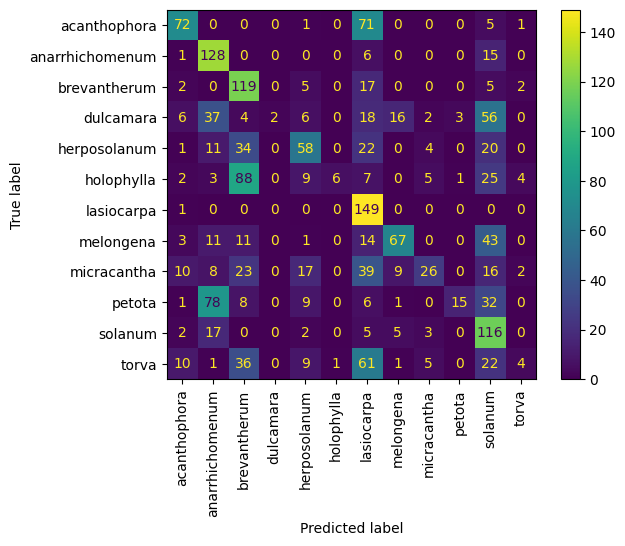

In [ ]:
# Fetch the best model that was found
# Get the top 1 models.
models = random_tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

print(str(random_tuner.get_best_hyperparameters()[0].values))


val_gen = get_val_generator(bal_val_set,
                            tf.keras.applications.vgg16.preprocess_input,
                            batch_size=32)

val_model_predictions = best_model.predict(val_gen,
                                           #steps=val_gen.n // (val_gen.batch_size + 1)
                                           #steps=10
                                          )

pred_report = print_dataset_prediction_report(val_model_predictions,
                                              val_gen.classes,
                                              get_class_names(val_gen))

# Using best hyperparameters

## Preparation of training and validation data

In [15]:
# Let's focus on oversampling to 1500

MIN_NUM_CLASSES = 1500
sections_to_oversample = list(training_count_per_section[training_count_per_section["count"] < MIN_NUM_CLASSES]["section"].values)

oversampler = RandomOverSampler(sampling_strategy={k: MIN_NUM_CLASSES for k in sections_to_oversample},
                                random_state=RANDOM_SEED)

final_training_set = imbsample(oversampler, training_set)

# Shuffle the data
final_training_set = final_training_set.sample(frac=1,
                                               random_state=RANDOM_SEED).reset_index(drop=True)

final_train, final_val = split_balanced_dataset(final_training_set, is_verbose=False)

print_marquee("Training")
# display(final_train.head(10))
display(count_rows_by_column(final_train, "section"))

print_marquee("Validation")
# display(final_train.head(10))
display(count_rows_by_column(final_val, "section"))



************
* Training *
************


section  count
9            petota   1404
0      acanthophora   1350
1   anarrhichomenum   1350
2      brevantherum   1350
3         dulcamara   1350
4      herposolanum   1350
5        holophylla   1350
6        lasiocarpa   1350
7         melongena   1350
8       micracantha   1350
10          solanum   1350
11            torva   1350



**************
* Validation *
**************


section  count
9            petota    156
0      acanthophora    150
1   anarrhichomenum    150
2      brevantherum    150
3         dulcamara    150
4      herposolanum    150
5        holophylla    150
6        lasiocarpa    150
7         melongena    150
8       micracantha    150
10          solanum    150
11            torva    150

## Training of model using best hyperparameters

In [20]:
"""
Best Params found:

Trial summary
Hyperparameters:
pooling: max
learning_rate: 0.03
trainable_layers: -1
optimizer: adam
batch_size: 32
Score: 0.840624988079071

"""
LEARNING_RATE = 0.03
BATCH_SIZE = 32

def train_using_best_params(train_df,
                            val_df,
                            test_df = None,
                            is_binary_class: bool=False,
                            print_loss_graphs: bool=True,
                            print_model_info: bool=True):

    preproc_func = tf.keras.applications.vgg16.preprocess_input
    num_classes = len(train_df["section"].unique())
    classifier_activation = None if is_binary_class else 'softmax'
    loss = 'binary_crossentropy' if is_binary_class else 'categorical_crossentropy'

    train_data_gen = get_train_generator(preproc_func,
                                        train_df,
                                        batch_size=BATCH_SIZE)
    

    """
     Get the ImageNet weights and prevent the training of the network up until the FC layers
     
      We will include the top even though we will still perform fine-tuning on 
      the last 3 Dense layers (the Fully-Connected layers) because we want to
      have their weights not initialized to random values but to ImageNet weights.

      The reason for this is because during experimentation it was found that
      having the FC layers initialized to random weights prevented the Vgg16
      network from learning at all.

    """
    vgg16_imagenet = tf.keras.applications.vgg16.VGG16(
        include_top=True,
        weights='imagenet',
        input_shape=(224, 224, 3),
    )

    # Freeze all ImageNet layers, we will do fine tuning in new Dense layers
    #  this will allow us to fine tune with Dense layers pre-initialized to ImageNet weights
    for layer in vgg16_imagenet.layers:
        layer.trainable = False
    
    vgg16_tl_model = tf.keras.Sequential(
        [
            # Remove the 1000 ImageNet prediction layer to accomodate the new prediction layers
            *vgg16_imagenet.layers[:-1],
            tf.keras.layers.Dense(num_classes, activation="softmax"),
        ]
    )

    # Add an optimizer
    vgg16_tl_model.compile(optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                           loss=loss,
                           metrics=['accuracy'])

    # Add a progress bar and save checkpoints
    vgg16_tl_callbacks = [
        # create_model_checkpoint(os.path.join(DATA_ROOT_LOCATION, f"vgg16_tl_final.h5")),
        tf.keras.callbacks.ProgbarLogger(
            count_mode = 'steps',
            stateful_metrics = None
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0,
            patience=100,
            verbose=0,
            mode='auto',
            restore_best_weights=True
        )
    ]

    fit_params = {
                    "x": train_data_gen,
                    "epochs": 500,
                    "callbacks": vgg16_tl_callbacks,
                    "steps_per_epoch": 64,
                    "batch_size": BATCH_SIZE,
                    "workers": 10,
                    "verbose": 0,
                    "validation_data": get_val_generator(val_df,
                                                         preprocessing_func=preproc_func,
                                                         batch_size=BATCH_SIZE)
                    }
        
    with tf.device(TRAINING_DEVICE_NAME):

        vgg16_tl_training_history = vgg16_tl_model.fit(**fit_params)

        # Pass the raw DataFrame so that the ImageDataGen is generated properly
        #  We plug the test_set in the validation_data field to piggy back on the
        #  code that evaluates how well the final model is predicting output
        fit_params["validation_data"] = test_df if test_df else val_df
        
        
        _, pred_report = evaluate_model(vgg16_tl_model,
                                        vgg16_tl_training_history,
                                        fit_params=fit_params,
                                        preproc_func=preproc_func,
                                        print_loss_graphs=print_loss_graphs,
                                        print_model_info=print_model_info)
    
    return vgg16_tl_model, vgg16_tl_training_history

Found 16254 validated image filenames belonging to 12 classes.
Found 1806 validated image filenames belonging to 12 classes.


*****************
* Model Summary *
*****************
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 blo

C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

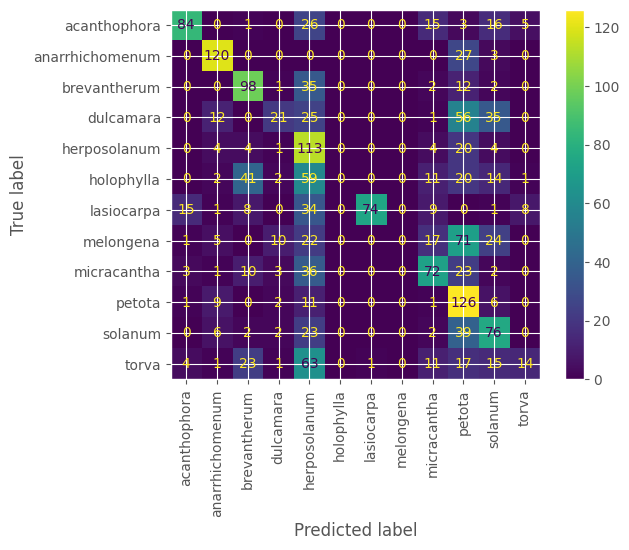



***********************************
* Confusion Matrix as percentages *
***********************************


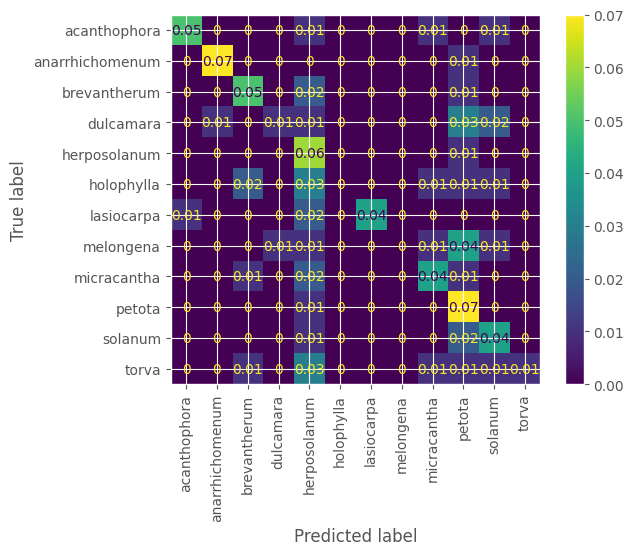



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


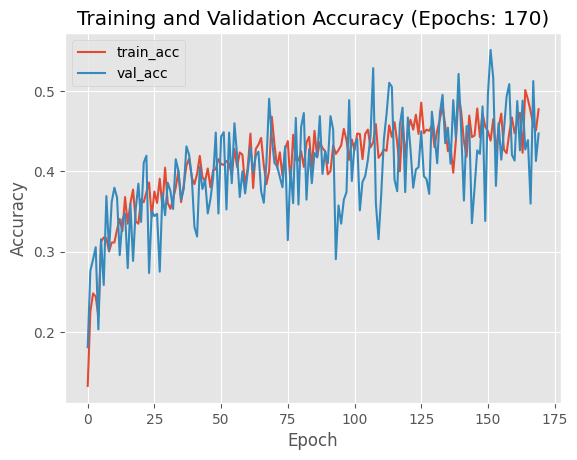

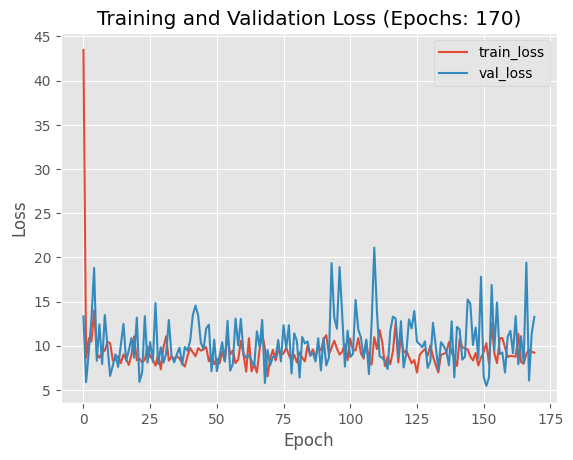

CPU times: total: 1h 29min 53s
Wall time: 19min 16s


In [ ]:
%%time
        
train_using_best_params(final_train, final_val)

## One vs many classes

We had very bad results for many of the classes, so in an effort to troubleshoot
what are the most problematic classes, we'll perform a One-vs-many binary classification approach to see what classes need to be worked on.



*************************
* acanthophora vs. many *
*************************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 51ms/step


*************************
* Classification Report *
*************************
                  precision    recall  f1-score   support

    acanthophora     0.5932    0.9333    0.7254       150
not-acanthophora     0.9936    0.9420    0.9671      1656

        accuracy                         0.9413      1806
       macro avg     0.7934    0.9377    0.8463      1806
    weighted avg     0.9604    0.9413    0.9471      1806



********************
* Confusion Matrix *
********************


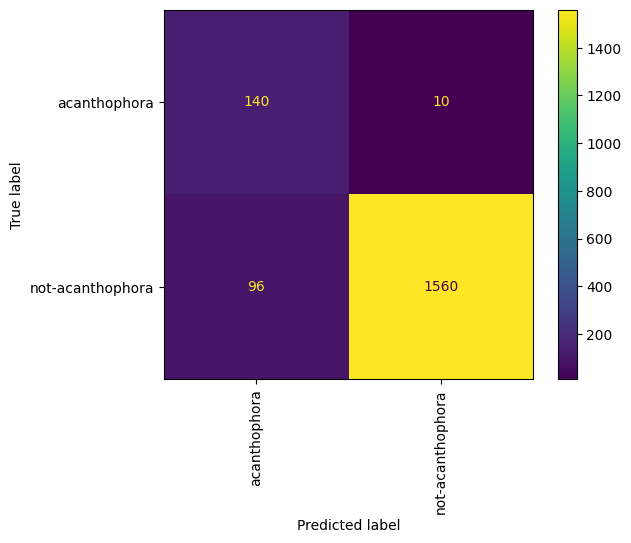



***********************************
* Confusion Matrix as percentages *
***********************************


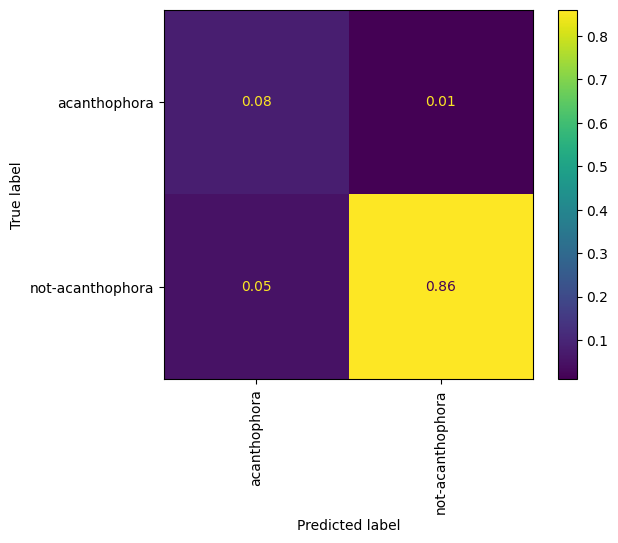



****************************
* anarrhichomenum vs. many *
****************************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 54ms/step


*************************
* Classification Report *
*************************
                     precision    recall  f1-score   support

    anarrhichomenum     0.7029    0.8200    0.7569       150
not-anarrhichomenum     0.9834    0.9686    0.9760      1656

           accuracy                         0.9563      1806
          macro avg     0.8432    0.8943    0.8664      1806
       weighted avg     0.9601    0.9563    0.9578      1806



********************
* Confusion Matrix *
********************


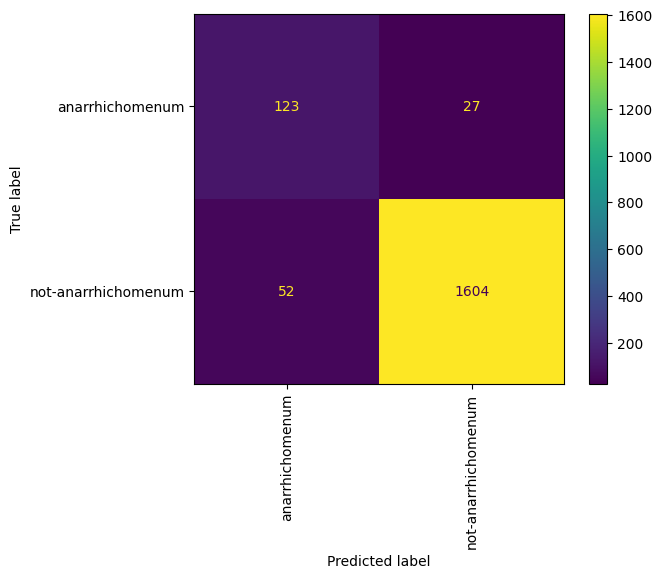



***********************************
* Confusion Matrix as percentages *
***********************************


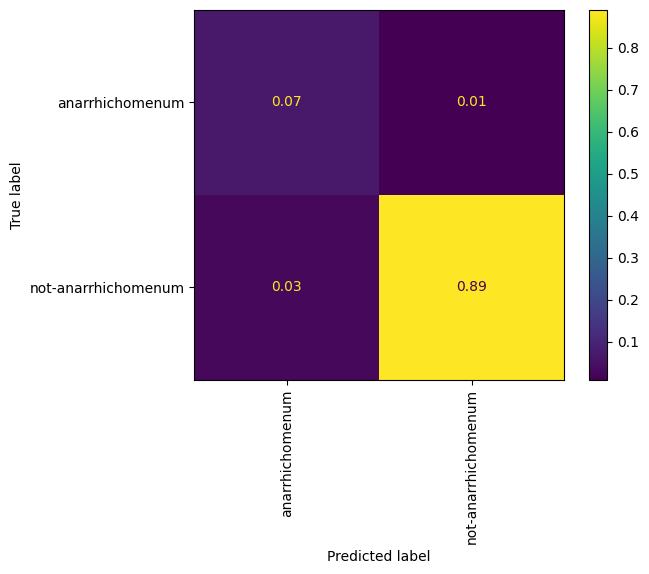



*************************
* brevantherum vs. many *
*************************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 55ms/step


*************************
* Classification Report *
*************************
                  precision    recall  f1-score   support

    brevantherum     1.0000    0.0067    0.0132       150
not-brevantherum     0.9175    1.0000    0.9569      1656

        accuracy                         0.9175      1806
       macro avg     0.9587    0.5033    0.4851      1806
    weighted avg     0.9243    0.9175    0.8786      1806



********************
* Confusion Matrix *
********************


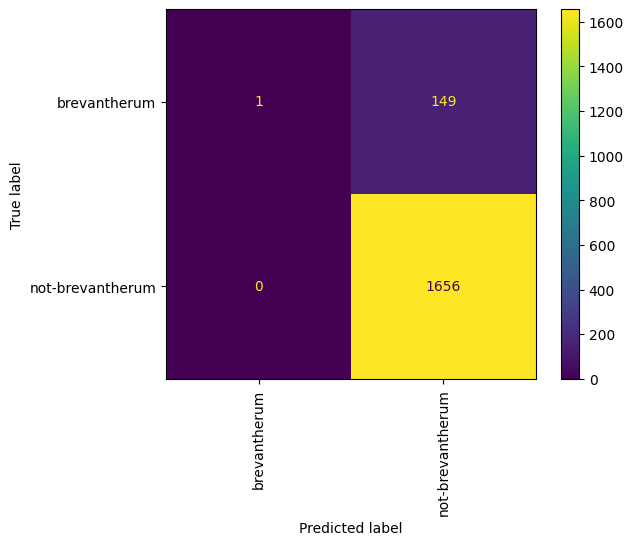



***********************************
* Confusion Matrix as percentages *
***********************************


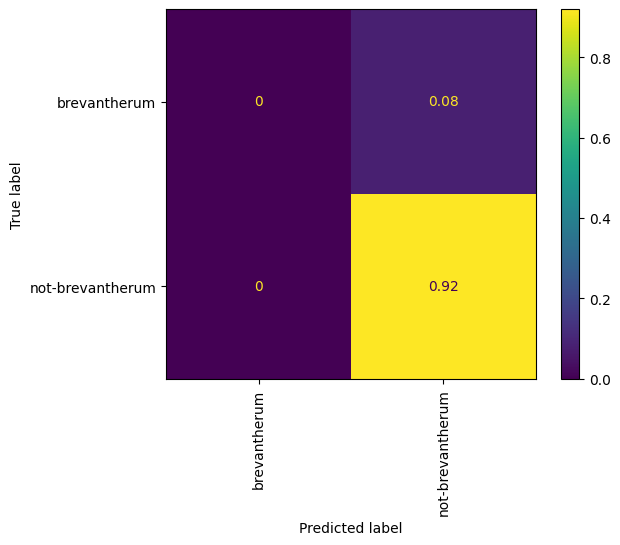



**********************
* dulcamara vs. many *
**********************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 54ms/step


*************************
* Classification Report *
*************************
               precision    recall  f1-score   support

    dulcamara     0.0000    0.0000    0.0000       150
not-dulcamara     0.9169    1.0000    0.9567      1656

     accuracy                         0.9169      1806
    macro avg     0.4585    0.5000    0.4783      1806
 weighted avg     0.8408    0.9169    0.8772      1806



********************
* Confusion Matrix *
********************


C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

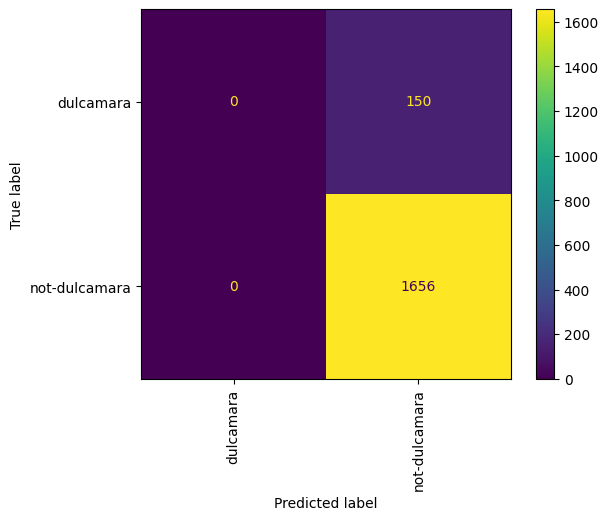



***********************************
* Confusion Matrix as percentages *
***********************************


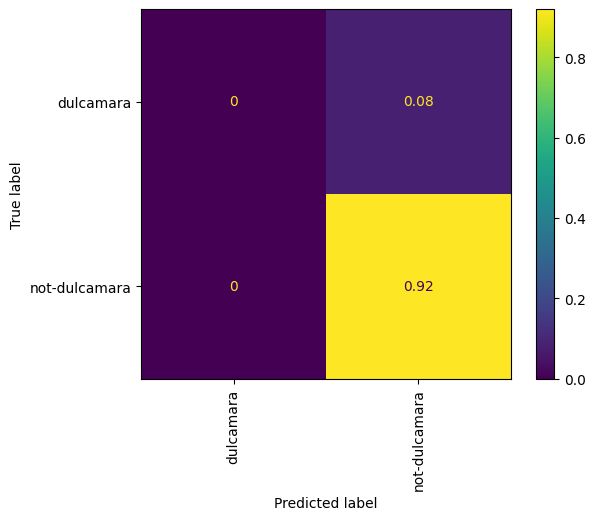



*************************
* herposolanum vs. many *
*************************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 54ms/step


*************************
* Classification Report *
*************************
                  precision    recall  f1-score   support

    herposolanum     0.4943    0.5733    0.5309       150
not-herposolanum     0.9608    0.9469    0.9538      1656

        accuracy                         0.9158      1806
       macro avg     0.7275    0.7601    0.7423      1806
    weighted avg     0.9220    0.9158    0.9186      1806



********************
* Confusion Matrix *
********************


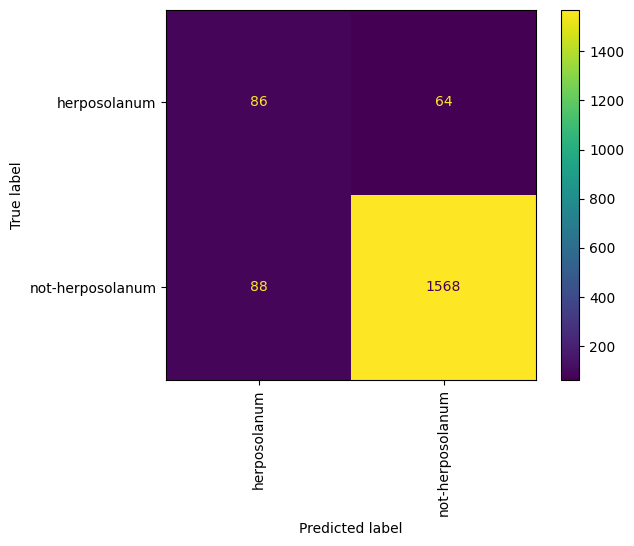



***********************************
* Confusion Matrix as percentages *
***********************************


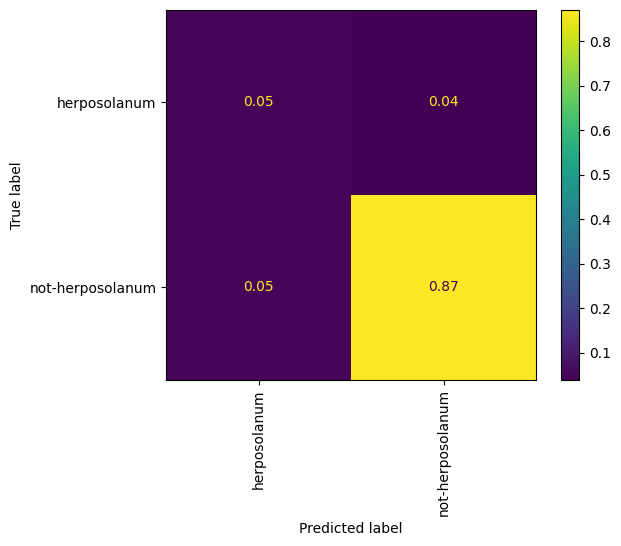



***********************
* holophylla vs. many *
***********************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 53ms/step


*************************
* Classification Report *
*************************
                precision    recall  f1-score   support

    holophylla     0.4591    0.4867    0.4725       150
not-holophylla     0.9532    0.9481    0.9507      1656

      accuracy                         0.9097      1806
     macro avg     0.7062    0.7174    0.7116      1806
  weighted avg     0.9122    0.9097    0.9109      1806



********************
* Confusion Matrix *
********************


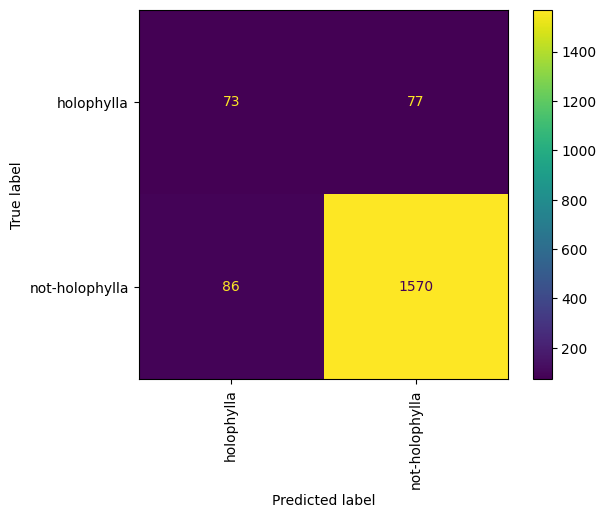



***********************************
* Confusion Matrix as percentages *
***********************************


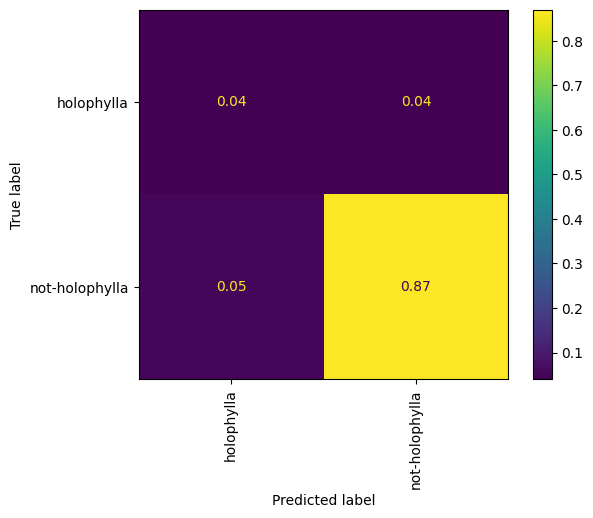



***********************
* lasiocarpa vs. many *
***********************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 53ms/step


*************************
* Classification Report *
*************************
                precision    recall  f1-score   support

    lasiocarpa     0.8679    0.6133    0.7187       150
not-lasiocarpa     0.9659    0.9915    0.9785      1656

      accuracy                         0.9601      1806
     macro avg     0.9169    0.8024    0.8486      1806
  weighted avg     0.9577    0.9601    0.9570      1806



********************
* Confusion Matrix *
********************


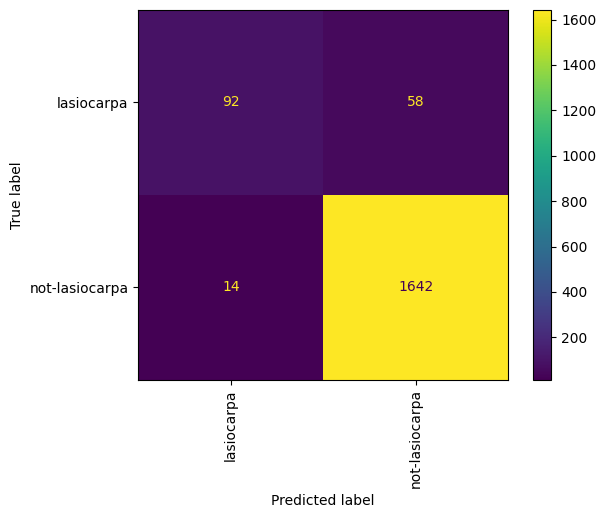



***********************************
* Confusion Matrix as percentages *
***********************************


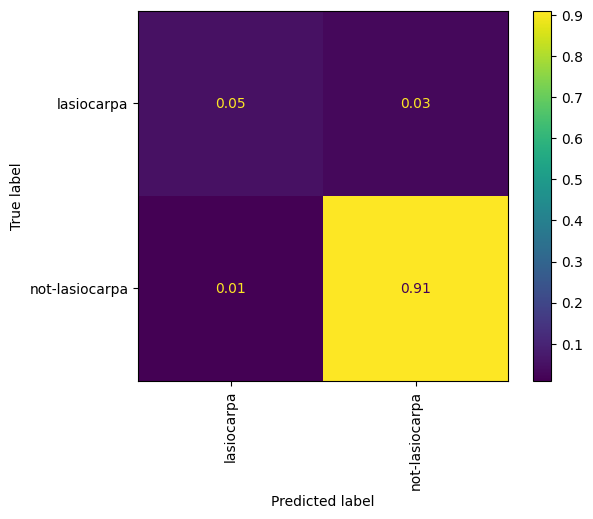



**********************
* melongena vs. many *
**********************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 55ms/step


*************************
* Classification Report *
*************************
               precision    recall  f1-score   support

    melongena     0.9070    0.2600    0.4041       150
not-melongena     0.9370    0.9976    0.9664      1656

     accuracy                         0.9363      1806
    macro avg     0.9220    0.6288    0.6853      1806
 weighted avg     0.9345    0.9363    0.9197      1806



********************
* Confusion Matrix *
********************


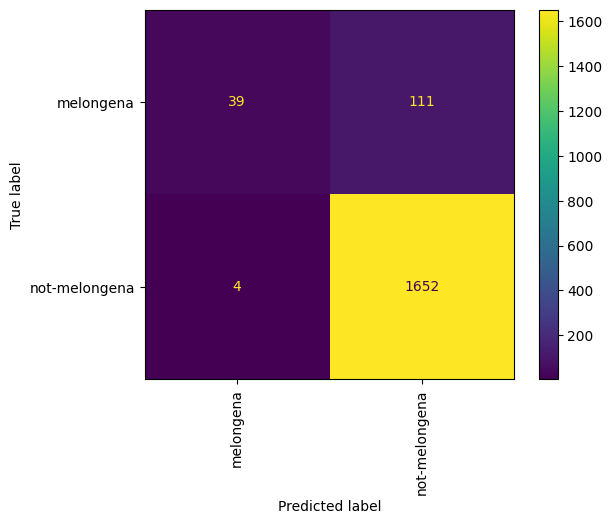



***********************************
* Confusion Matrix as percentages *
***********************************


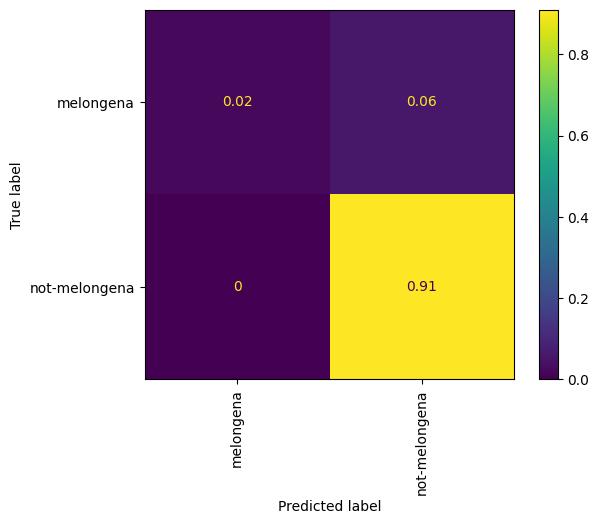



************************
* micracantha vs. many *
************************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 54ms/step


*************************
* Classification Report *
*************************
                 precision    recall  f1-score   support

    micracantha     0.8571    0.1600    0.2697       150
not-micracantha     0.9291    0.9976    0.9621      1656

       accuracy                         0.9280      1806
      macro avg     0.8931    0.5788    0.6159      1806
   weighted avg     0.9232    0.9280    0.9046      1806



********************
* Confusion Matrix *
********************


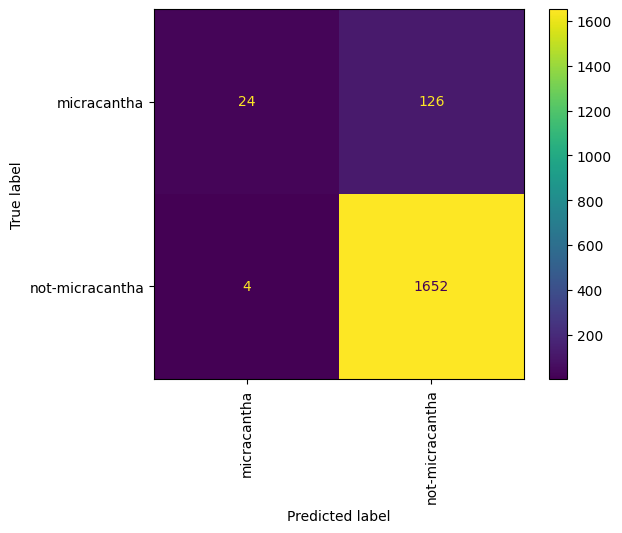



***********************************
* Confusion Matrix as percentages *
***********************************


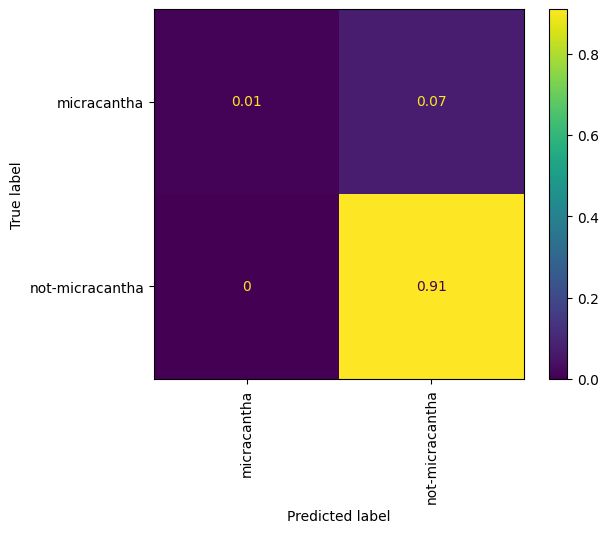



*******************
* petota vs. many *
*******************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 54ms/step


*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

  not-petota     0.9412    0.9794    0.9599      1650
      petota     0.6180    0.3526    0.4490       156

    accuracy                         0.9252      1806
   macro avg     0.7796    0.6660    0.7044      1806
weighted avg     0.9133    0.9252    0.9158      1806



********************
* Confusion Matrix *
********************


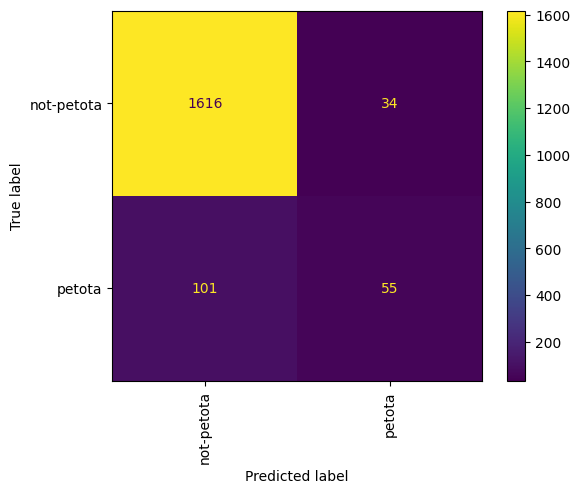



***********************************
* Confusion Matrix as percentages *
***********************************


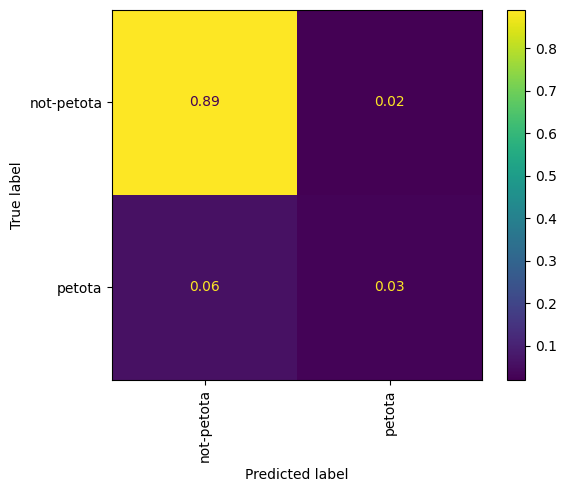



********************
* solanum vs. many *
********************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 52ms/step


*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

 not-solanum     0.9220    0.9988    0.9588      1656
     solanum     0.8333    0.0667    0.1235       150

    accuracy                         0.9214      1806
   macro avg     0.8776    0.5327    0.5411      1806
weighted avg     0.9146    0.9214    0.8895      1806



********************
* Confusion Matrix *
********************


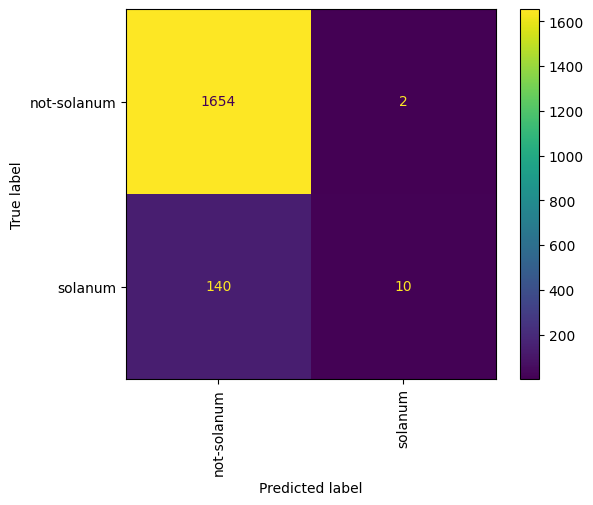



***********************************
* Confusion Matrix as percentages *
***********************************


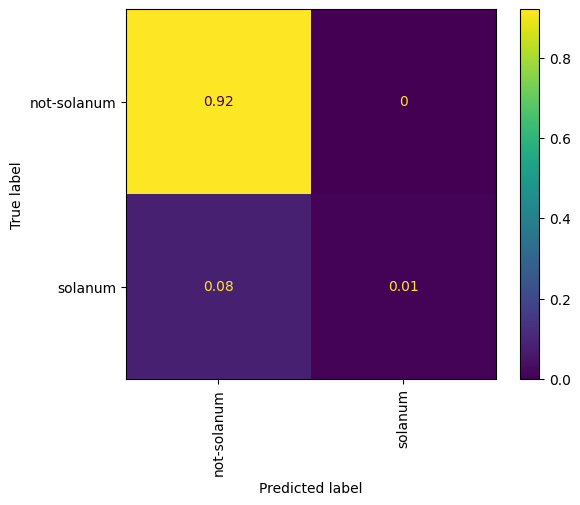



******************
* torva vs. many *
******************
Found 16254 validated image filenames belonging to 2 classes.
Found 1806 validated image filenames belonging to 2 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1806 validated image filenames belonging to 2 classes.
57/57 [==============================] - 3s 54ms/step


*************************
* Classification Report *
*************************
              precision    recall  f1-score   support

   not-torva     0.9511    0.9269    0.9388      1656
       torva     0.3698    0.4733    0.4152       150

    accuracy                         0.8893      1806
   macro avg     0.6604    0.7001    0.6770      1806
weighted avg     0.9028    0.8893    0.8953      1806



********************
* Confusion Matrix *
********************


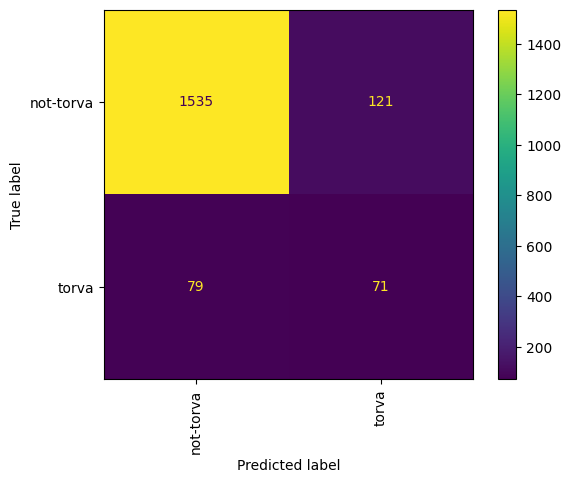



***********************************
* Confusion Matrix as percentages *
***********************************


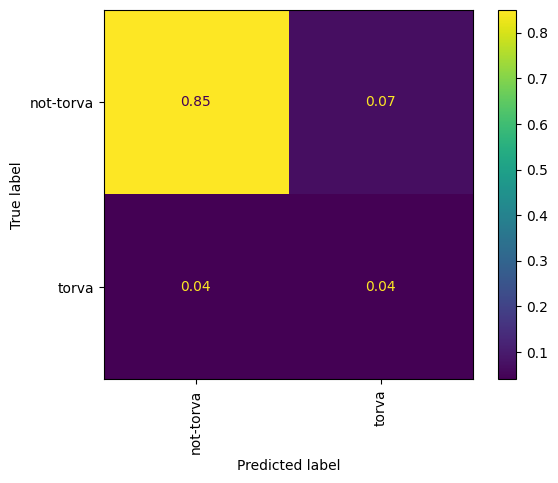

CPU times: total: 16h 9min 14s
Wall time: 4h 1min 42s


In [ ]:
%%time

def transform_to_binary_class(df, section_name: str):
    df = df.copy()
    df.loc[df["section"] != section_name, "section"] = f"not-{section_name}"
    return df


for section_name in np.sort(final_train["section"].unique()):

    print_marquee(f"{section_name} vs. many")

    one_vs_many_train_df = transform_to_binary_class(final_train, section_name)
    one_vs_many_val_df = transform_to_binary_class(final_val, section_name)

    train_using_best_params(one_vs_many_train_df,
                            one_vs_many_val_df,
                            is_binary_class=True,
                            print_loss_graphs=False,
                            print_model_info=False)

In [ ]:
%%time

def transform_to_binary_class(df, section_name: str):
    df = df.copy()
    df.loc[df["section"] != section_name, "section"] = f"not-{section_name}"
    return df


for section_name in np.sort(final_train["section"].unique()):

    print_marquee(f"{section_name} vs. many")

    one_vs_many_train_df = transform_to_binary_class(final_train, section_name)
    one_vs_many_val_df = transform_to_binary_class(final_val, section_name)

    train_using_best_params(one_vs_many_train_df,
                            one_vs_many_val_df,
                            is_binary_class=True,
                            print_loss_graphs=False,
                            print_model_info=False)


Output hidden; open in https://colab.research.google.com to view.

## Removing problematic sections

As we can see there are a couple of sections that are not being recognized by the neural network at all and might be introducing too much noise, let's now train a model without the problematic sections and see how the model behaves, we can evaluate later why the problematic sections are deemed so and propose how we could attack that problem.

For this part, we'll remove the classes that were not identified at all and those that had less than 40% F1-Score.

1. Dulcamara 0.3719
1. Herposolanum 0.3542
1. holophylla 0.0
1. melongena 0.2414
1. solanum 0.3412
1. torva 0.0

1. Brevantherum 0.0132
2. Dulcamara 0.0
3. Micracantha 0.2697
4. Solanum 0.1235



In [ ]:
problematic_sections = [
    "dulcamara",
    "herposolanum",
    "holophylla",
    "melongena",
    "solanum",
    "torva"
    ]

print_marquee("Non-problematic training count")
no_problematic_train_df = final_train[~final_train.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_train_df, "section"))

print_marquee("Non-problematic validation count")
no_problematic_val_df = final_val[~final_val.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_val_df, "section"))



**********************************
* Non-problematic training count *
**********************************


section  count
8           petota   1404
0     acanthophora   1350
1  anarrhichomenum   1350
2     brevantherum   1350
3        dulcamara   1350
4     herposolanum   1350
5       lasiocarpa   1350
6        melongena   1350
7      micracantha   1350
9          solanum   1350



************************************
* Non-problematic validation count *
************************************


section  count
8           petota    156
0     acanthophora    150
1  anarrhichomenum    150
2     brevantherum    150
3        dulcamara    150
4     herposolanum    150
5       lasiocarpa    150
6        melongena    150
7      micracantha    150
9          solanum    150



**********************************
* Non-problematic training count *
**********************************


section  count
6           petota   1404
0     acanthophora   1350
1  anarrhichomenum   1350
2     herposolanum   1350
3       holophylla   1350
4       lasiocarpa   1350
5        melongena   1350
7            torva   1350



************************************
* Non-problematic validation count *
************************************


section  count
6           petota    156
0     acanthophora    150
1  anarrhichomenum    150
2     herposolanum    150
3       holophylla    150
4       lasiocarpa    150
5        melongena    150
7            torva    150

Found 10854 validated image filenames belonging to 8 classes.
Found 1206 validated image filenames belonging to 8 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 1206 validated image filenames belonging to 8 classes.
38/38 [==============================] - 2s 51ms/step


*************************
* Classification Report *
*************************
                 precision    recall  f1-score   support

   acanthophora     0.5403    0.8933    0.6734       150
anarrhichomenum     1.0000    0.0667    0.1250       150
   herposolanum     0.5000    0.6333    0.5588       150
     holophylla     0.6341    0.6933    0.6624       150
     lasiocarpa     0.8943    0.7333    0.8059       150
      melongena     0.9492    0.3733    0.5359       150
         petota     0.3434    0.8718    0.4928       156
          torva     0.7500    0.0800    0.1446       150

       accuracy                         0.544

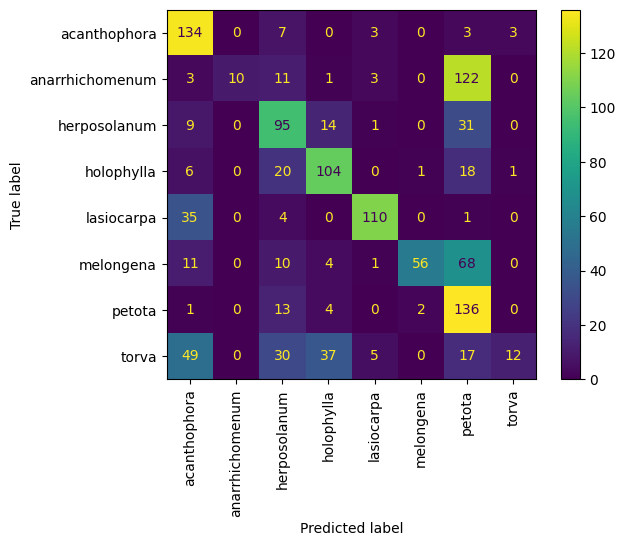



***********************************
* Confusion Matrix as percentages *
***********************************


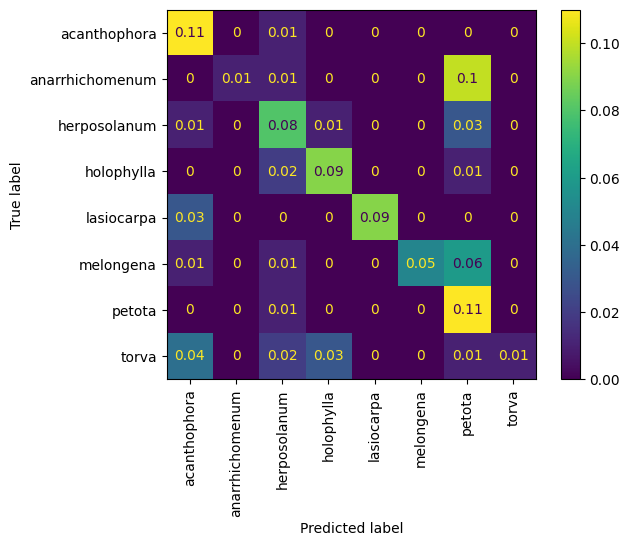



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


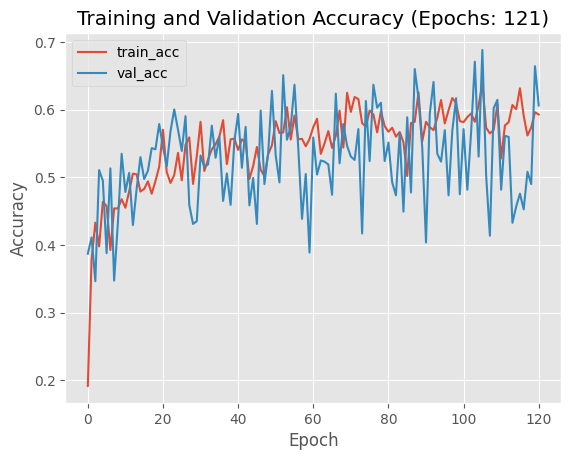

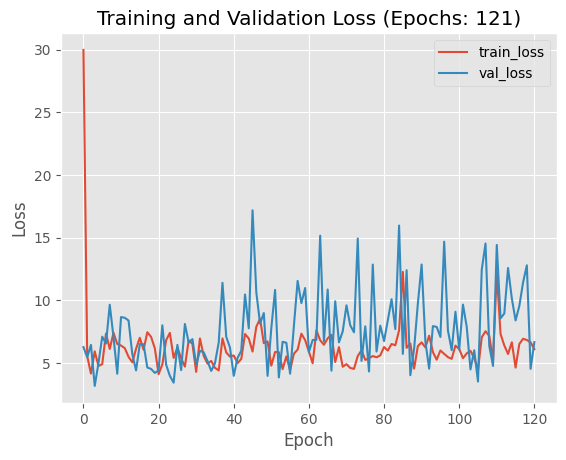

CPU times: total: 54min 19s
Wall time: 11min 44s


In [17]:
%%time

problematic_sections = [
    "brevantherum",
    "dulcamara",
    # "herposolanum",
    # "holophylla",
    # "melongena",
    "solanum",
    "micracantha",
    # "torva"
    ]

print_marquee("Non-problematic training count")
no_problematic_train_df = final_train[~final_train.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_train_df, "section"))

print_marquee("Non-problematic validation count")
no_problematic_val_df = final_val[~final_val.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_val_df, "section"))

train_using_best_params(no_problematic_train_df,
                        no_problematic_val_df,
                        print_loss_graphs=True,
                        print_model_info=False)



**********************************
* Non-problematic training count *
**********************************


section  count
5           petota   1404
0     acanthophora   1350
1  anarrhichomenum   1350
2     brevantherum   1350
3       lasiocarpa   1350
4      micracantha   1350



************************************
* Non-problematic validation count *
************************************


section  count
5           petota    156
0     acanthophora    150
1  anarrhichomenum    150
2     brevantherum    150
3       lasiocarpa    150
4      micracantha    150

Found 8154 validated image filenames belonging to 6 classes.
Found 906 validated image filenames belonging to 6 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 906 validated image filenames belonging to 6 classes.
29/29 [==============================] - 2s 53ms/step


*************************
* Classification Report *
*************************
                 precision    recall  f1-score   support

   acanthophora     0.7333    0.9533    0.8290       150
anarrhichomenum     0.8630    0.8400    0.8514       150
   brevantherum     0.8506    0.8733    0.8618       150
     lasiocarpa     1.0000    0.6067    0.7552       150
    micracantha     0.8661    0.7333    0.7942       150
         petota     0.6943    0.8590    0.7679       156

       accuracy                         0.8113       906
      macro avg     0.8346    0.8109    0.8099       906
   weighted avg     0.8336    0.8113    0.8096  

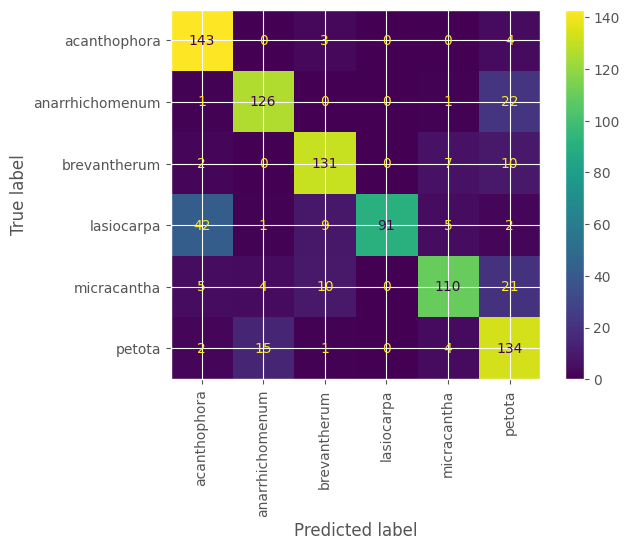



***********************************
* Confusion Matrix as percentages *
***********************************


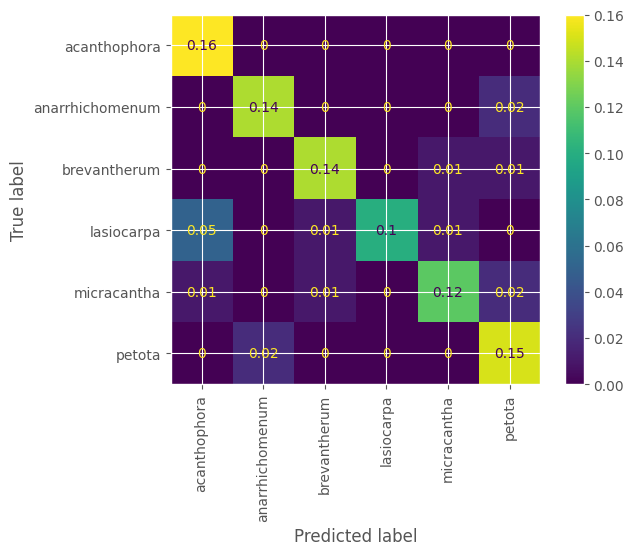



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


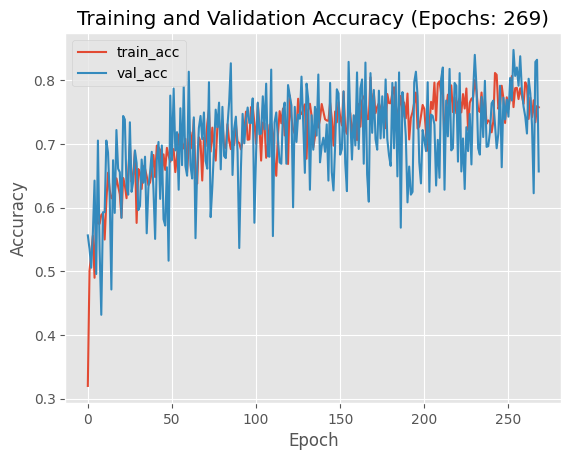

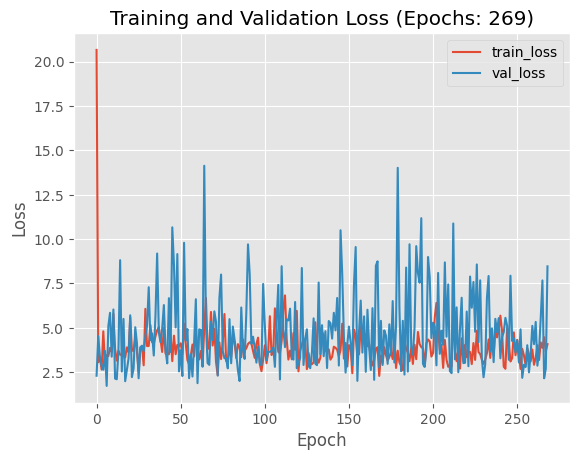

CPU times: total: 1h 58min 25s
Wall time: 23min 16s


In [24]:
%%time

problematic_sections = [
    "dulcamara",
    "herposolanum",
    "holophylla",
    "melongena",
    "solanum",
    "torva"
    ]

print_marquee("Non-problematic training count")
no_problematic_train_df = final_train[~final_train.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_train_df, "section"))

print_marquee("Non-problematic validation count")
no_problematic_val_df = final_val[~final_val.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_val_df, "section"))

vgg16_m, vgg16_h = train_using_best_params(no_problematic_train_df,
                        no_problematic_val_df,
                        print_loss_graphs=True,
                        print_model_info=False)

In [25]:
# vgg16_m.save(os.path.join(DATA_ROOT_LOCATION, f"vgg16_tl_best_no_problematic_sections_80acc.h5"))



*****************
* Model Summary *
*****************
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                

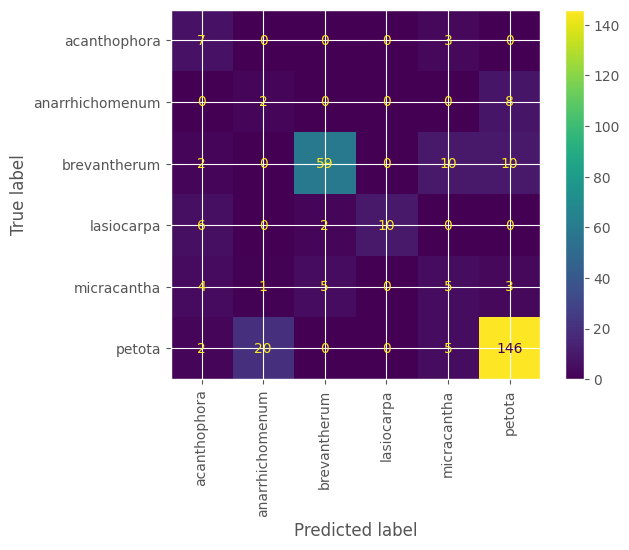



***********************************
* Confusion Matrix as percentages *
***********************************


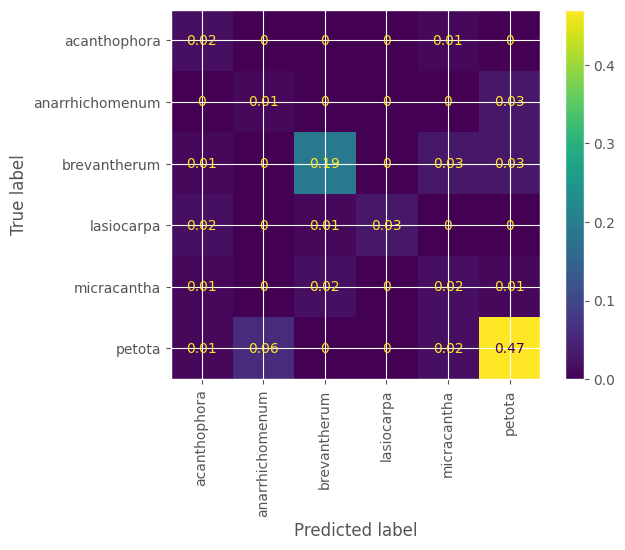



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


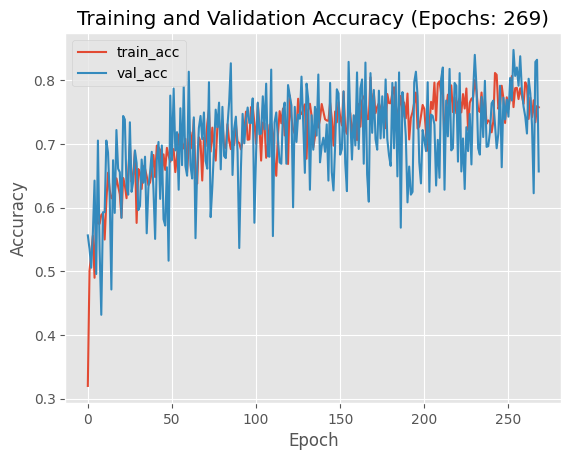

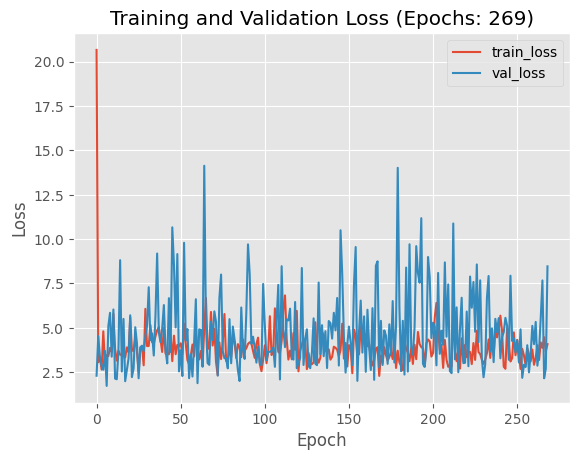

In [30]:
no_problematic_test_df = test_set[~test_set.section.isin(problematic_sections)]
fit_params = {
                    "epochs": 500,
                    "steps_per_epoch": 64,
                    "batch_size": BATCH_SIZE,
                    "workers": 10,
                    "verbose": 0,
                    "validation_data": no_problematic_test_df
                    }
        
with tf.device(TRAINING_DEVICE_NAME):
    
    _, pred_report = evaluate_model(vgg16_m,
                                    vgg16_h,
                                    fit_params=fit_params,
                                    preproc_func=tf.keras.applications.vgg16.preprocess_input,
                                    print_loss_graphs=True,
                                    print_model_info=True)



**********************************
* Non-problematic training count *
**********************************


section  count
5           petota   1404
0     acanthophora   1350
1  anarrhichomenum   1350
2     brevantherum   1350
3       lasiocarpa   1350
4      micracantha   1350



************************************
* Non-problematic validation count *
************************************


section  count
5           petota    156
0     acanthophora    150
1  anarrhichomenum    150
2     brevantherum    150
3       lasiocarpa    150
4      micracantha    150

Found 8154 validated image filenames belonging to 6 classes.
Found 906 validated image filenames belonging to 6 classes.


***************************************
* Validation Dataset Confusion Matrix *
***************************************
Found 906 validated image filenames belonging to 6 classes.
29/29 [==============================] - 2s 50ms/step


*************************
* Classification Report *
*************************
                 precision    recall  f1-score   support

   acanthophora     0.9071    0.8467    0.8759       150
anarrhichomenum     0.5952    1.0000    0.7463       150
   brevantherum     0.9085    0.8600    0.8836       150
     lasiocarpa     0.9489    0.8667    0.9059       150
    micracantha     0.7391    0.9067    0.8144       150
         petota     0.9412    0.3077    0.4638       156

       accuracy                         0.7947       906
      macro avg     0.8400    0.7979    0.7816       906
   weighted avg     0.8407    0.7947    0.7795  

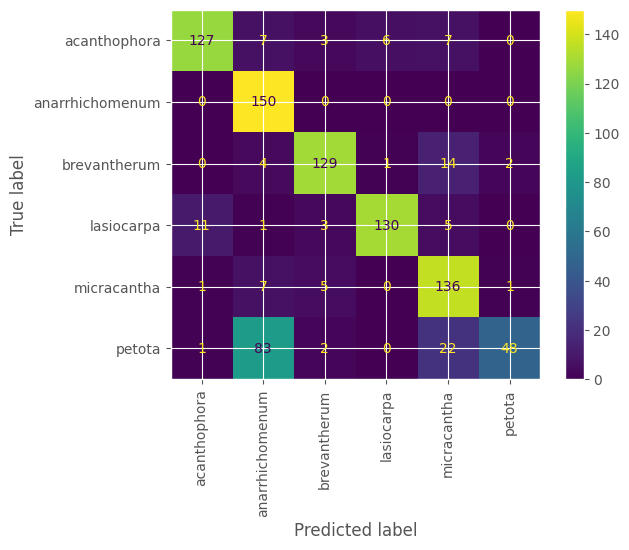



***********************************
* Confusion Matrix as percentages *
***********************************


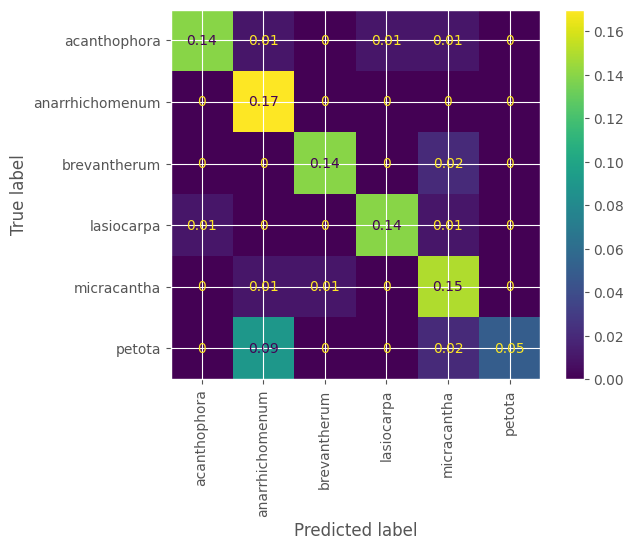



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


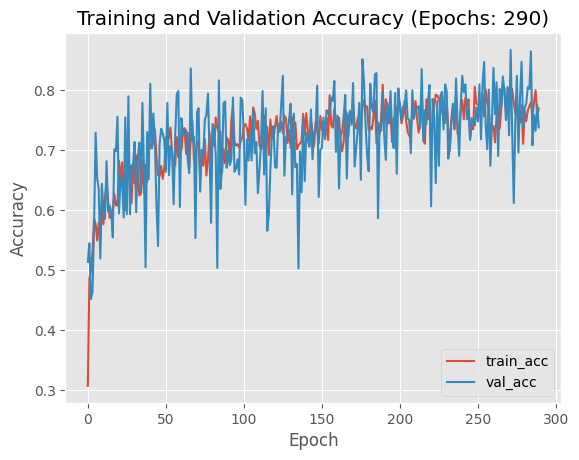

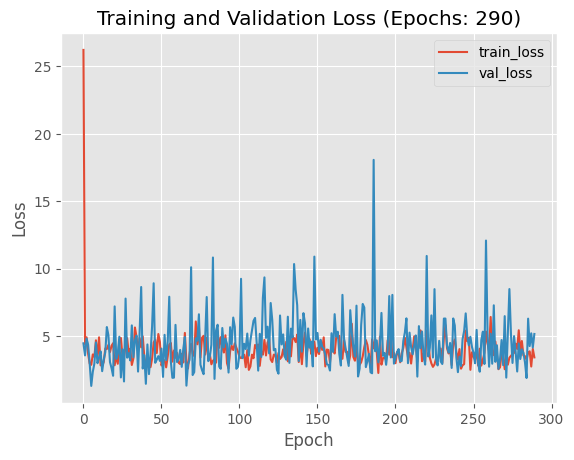

CPU times: total: 2h 5min 47s
Wall time: 25min 1s


In [19]:
%%time

problematic_sections = [
    "dulcamara",
    "herposolanum",
    "holophylla",
    "melongena",
    "solanum",
    "torva"
    ]

print_marquee("Non-problematic training count")
no_problematic_train_df = final_train[~final_train.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_train_df, "section"))

print_marquee("Non-problematic validation count")
no_problematic_val_df = final_val[~final_val.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_val_df, "section"))

train_using_best_params(no_problematic_train_df,
                        no_problematic_val_df,
                        print_loss_graphs=True,
                        print_model_info=False)

Found 8154 validated image filenames belonging to 6 classes.
Found 906 validated image filenames belonging to 6 classes.


*****************
* Model Summary *
*****************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_poo

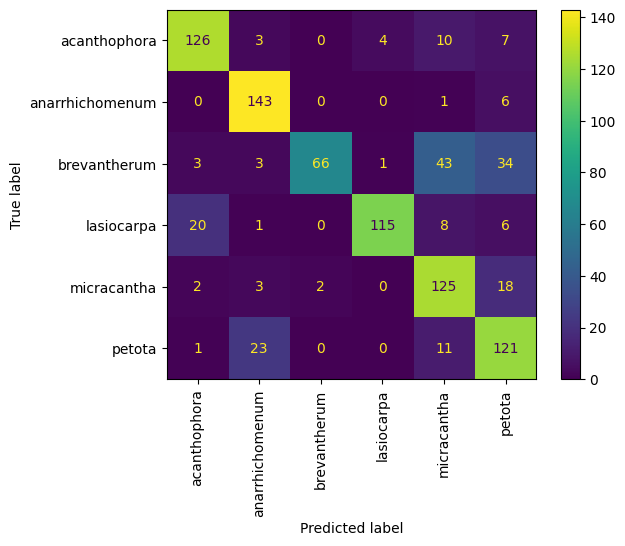



***********************************
* Confusion Matrix as percentages *
***********************************


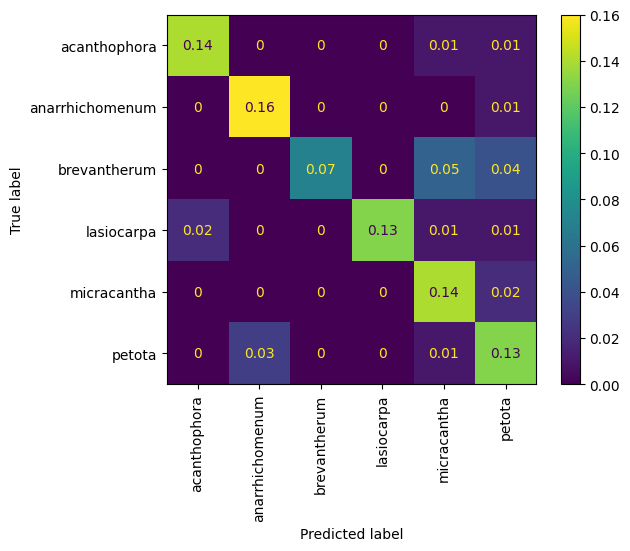



**************************************
* Train/Val Accuracy and Loss graphs *
**************************************


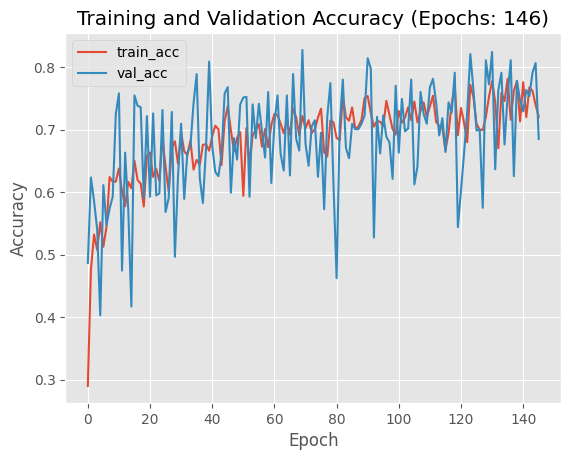

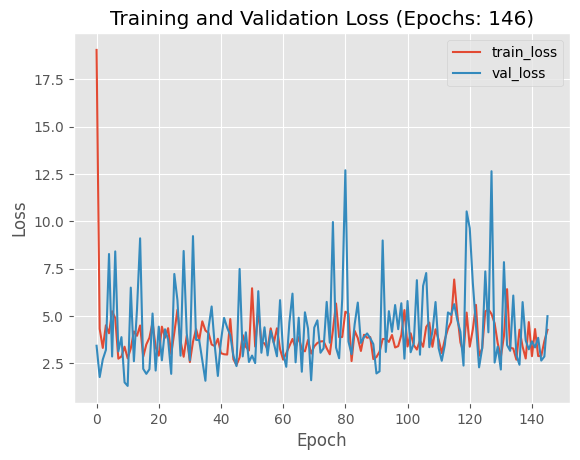

CPU times: total: 1h 2min 15s
Wall time: 12min 26s


In [ ]:
%%time

problematic_sections = [
    "dulcamara",
    "herposolanum",
    "holophylla",
    "melongena",
    "solanum",
    "torva"
    ]

print_marquee("Non-problematic training count")
no_problematic_train_df = final_train[~final_train.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_train_df, "section"))

print_marquee("Non-problematic validation count")
no_problematic_val_df = final_val[~final_val.section.isin(problematic_sections)]
display(count_rows_by_column(no_problematic_val_df, "section"))

train_using_best_params(no_problematic_train_df,
                        no_problematic_val_df,
                        print_loss_graphs=True,
                        print_model_info=False)